#### Load Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import h5py
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smt
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Import Utility Functions
sys.path.append("/content/drive/MyDrive") # Change utility_functions.py file path to local location
from  utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

import seaborn as sns
sns.set_style('white')

# The snippet below is for better visualization
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
# plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
# rcParams['font.family'] = plot_font

rcParams.update({'font.size': 10})

rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (5,5)})
rcParams.update({'savefig.dpi': 300})
rcParams.update({'axes.labelsize': 10})

import warnings
warnings.filterwarnings('ignore')

#### Data Loading, QC, Normalization

Construct expression dataframes including foci and features of interest.

In [4]:
# Read the data (.csv file) into dataframe
file_path = "/content/drive/My Drive/20220914_MCF7_IR_merged_annotated.csv" # change file path to local location
data = pd.read_csv(file_path)

In [5]:
data['guide'] = data['guide'].astype(str)
data["ID"] = data.index

In [6]:
# Construct expression df
cols = ["ID", "guide", "RAD51_foci", "BRCA1_foci", "X53BP1_foci", "yH2AX_foci", "micronuclei", "cell_cycle"]
expr_df = data.loc[:, cols]
expr_df.head()

# Normalize expression per foci for all foci across guides - Not normalized for KS and Wasserstein
# expr_df[["RAD51_foci", "BRCA1_foci", "X53BP1_foci", "yH2AX_foci", "micronuclei"]] = expr_df[["RAD51_foci", "BRCA1_foci", "X53BP1_foci", "yH2AX_foci", "micronuclei"]].apply(lambda x: (x-x.mean()) / np.std(x, ddof=1), axis=0)


,ID,guide,RAD51_foci,BRCA1_foci,X53BP1_foci,yH2AX_foci,micronuclei,cell_cycle
0,0,AAVS1.controls.AAVS1.100,0,0,1,2,0,G1
1,1,AAVS1.controls.AAVS1.100,6,5,2,4,0,G2/S
2,2,AAVS1.controls.AAVS1.100,0,3,1,2,0,G1
3,3,AAVS1.controls.AAVS1.100,16,17,0,1,0,G2/S
4,4,AAVS1.controls.AAVS1.100,5,6,2,3,1,G2/S


#### Define Non-Targeting, AAVS1 and Perturbation Lists
Define three lists containning guides under Non-Targeting Control, AAVS1 Control and Perturbations. In this dataset, there should be:

*   Non-Targeting Controls: 34 unique guides
*   AAVS1 Controls: 32 unique guides
*   Perturbations: 275 unique guides


In [7]:
from collections import Counter

In [8]:
# Initiate three empty lists for Non-Targeting(NT), AAVS1(AAVS), and Perturbations(Perturb)
NT_list = []
AAVS_list = []
perturb_list = []

# Loop through all guides and append guides under each associated class
for i in expr_df["guide"]:
    if "targeting" in i:
        NT_list.append(str(i))
    elif "AAVS" in i:
        string_list = str(i).split(".") # Change the original guide name (AAVS1.controls.AAVS1.###) to AAVS1.###
        AAVS_list.append(".".join([string_list[2],  string_list[3]]))
    else:
        string_list = str(i).split(".") # Change the original guide name (Core.Perturbation.###) to Perturbation.###
        perturb_list.append(".".join([string_list[1],  string_list[2]]))

# Store unique guides in each class and their frequencies (number of cells under that guide) in dictionaries
NT_freq = Counter(NT_list)
NT_dict = dict(NT_freq)

AAVS_freq = Counter(AAVS_list)
AAVS_dict = dict(AAVS_freq)

perturb_freq = Counter(perturb_list)
perturb_dict = dict(perturb_freq)

# Define lists for unique for Non-Targeting(NT), AAVS1(AAVS), and Perturbations(Perturb) guides
NT_list = np.unique(NT_list).tolist()
AAVS_list = np.unique(AAVS_list).tolist()
perturb_list = np.unique(perturb_list).tolist()

#### Cell Cycle Foci Expression Visualization
Visualize how cells in different stages of the cell cycle may exhibit different foci expression.

In [9]:
# Binarize the cell_cycle feature
expr_df["cell_cycle"] = expr_df["cell_cycle"].astype(str)
expr_df["cell_cycle"] = expr_df["cell_cycle"].apply(lambda x: cc_binary(x))
expr_df.head()

,ID,guide,RAD51_foci,BRCA1_foci,X53BP1_foci,yH2AX_foci,micronuclei,cell_cycle
0,0,AAVS1.controls.AAVS1.100,0,0,1,2,0,0
1,1,AAVS1.controls.AAVS1.100,6,5,2,4,0,1
2,2,AAVS1.controls.AAVS1.100,0,3,1,2,0,0
3,3,AAVS1.controls.AAVS1.100,16,17,0,1,0,1
4,4,AAVS1.controls.AAVS1.100,5,6,2,3,1,1


In [10]:
# Create a dataframe containning all guides, guide type and G1 cell proportion
cell_cycle_prop = pd.DataFrame()

columns = list(NT_list) + list(AAVS_list) + list(perturb_list)
cell_cycle_prop["guide"] = columns
cell_cycle_prop["G1_prop"] = None
cell_cycle_prop["type"] = None

for idx, guide in enumerate(cell_cycle_prop["guide"]):
    dataframe = get_df(guide, expr_df)
    G1, G2 = get_ccprp(dataframe)
    cell_cycle_prop.at[idx, "G1_prop"] = G1
    if guide in NT_list:
        cell_cycle_prop.at[idx, "type"] = "NT"
    elif guide in AAVS_list:
        cell_cycle_prop.at[idx, "type"] = "AAVS"
    else:
        cell_cycle_prop.at[idx, "type"] = "Per"

del idx, guide
cell_cycle_prop.head()

,guide,G1_prop,type
0,Non.targeting.controls..1,0.546868,NT
1,Non.targeting.controls..11,0.40796,NT
2,Non.targeting.controls..12,0.690909,NT
3,Non.targeting.controls..13,0.657143,NT
4,Non.targeting.controls..14,0.573705,NT


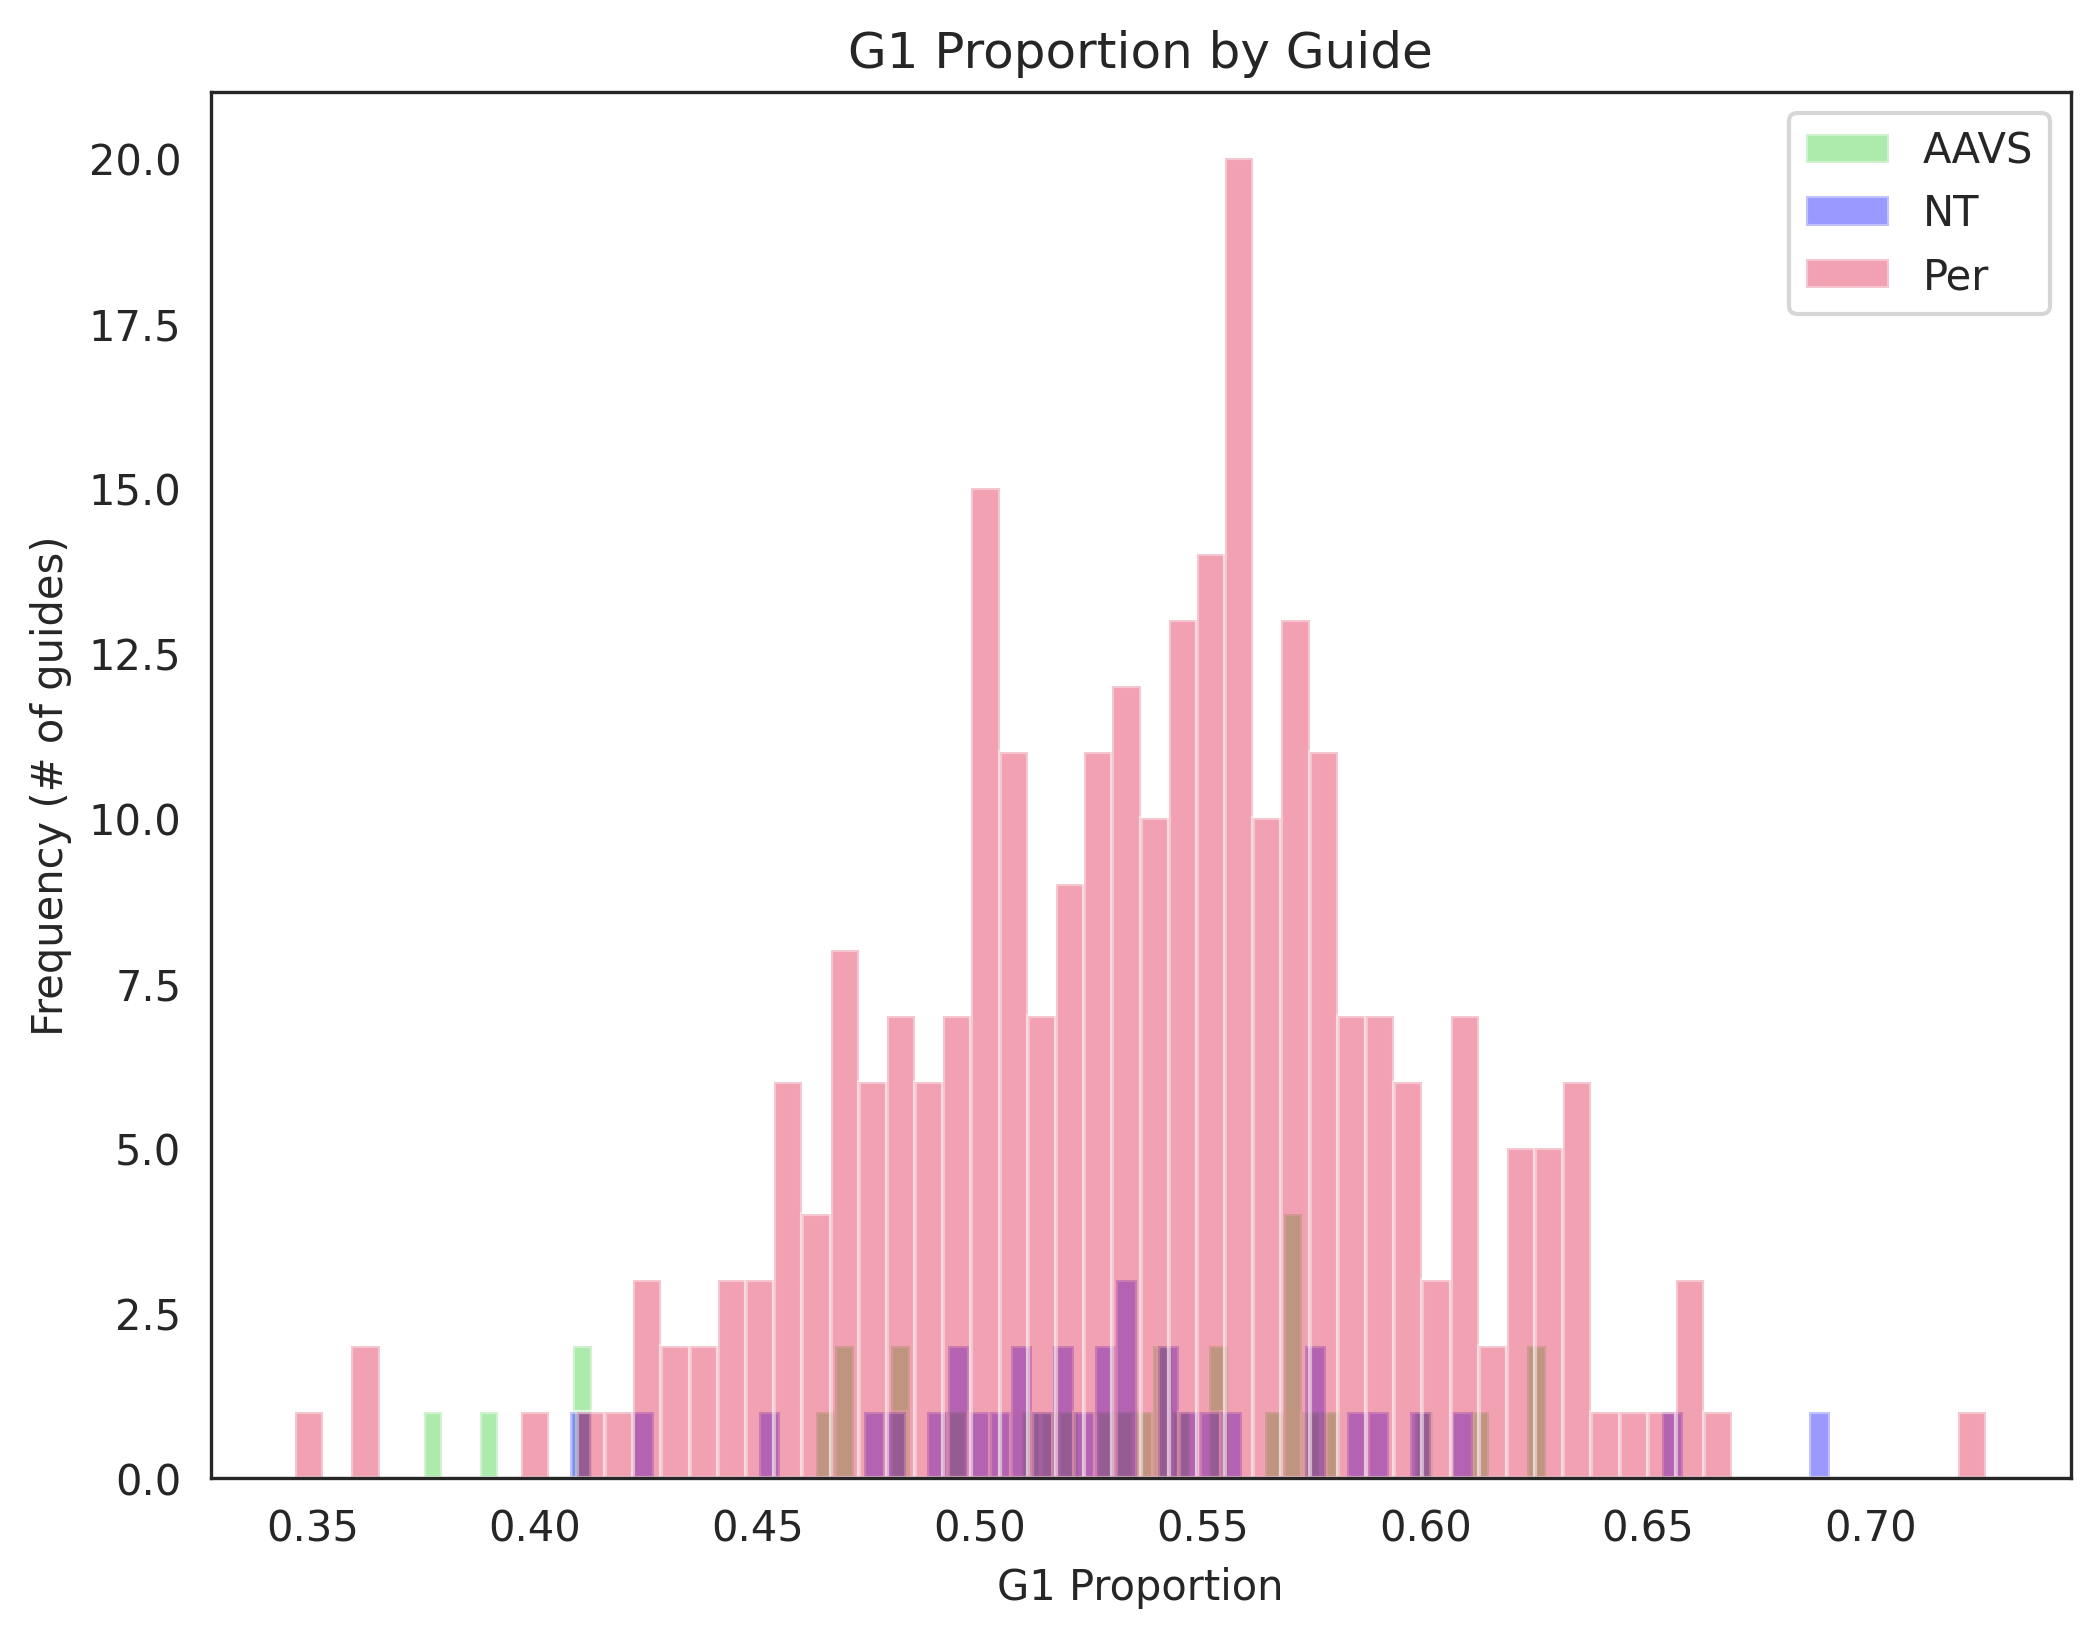

In [11]:
# Plot a histogram of G1 Proportion for all guides, colored by guide type
grouped_per = cell_cycle_prop.groupby('type')['G1_prop'].apply(list)
colors = ["limegreen", "blue", "crimson"]

# Plot histograms for each guide type
plt.figure(figsize=(8, 6))
for i, (type_, values) in enumerate(grouped_per.items()):
    plt.hist(values, bins=60, alpha=0.4, color=colors[i], label=type_) # density = True, if we normalize by AUC

del i, (type_, values)

# Add labels, title, and legend
plt.xlabel('G1 Proportion')
plt.ylabel('Frequency (# of guides)')
plt.title('G1 Proportion by Guide')
plt.legend()

# Show the plot
plt.show()

In [12]:
# Classify guides in the expression dataframe into: Non-targeting controls, AAVS1 controls and Perturbations.
expr_df["type"] = None

for idx, guide in enumerate(expr_df["guide"]):
    if "targeting" in guide:
        expr_df.at[idx, "type"] = "NT"
    elif "AAVS" in guide:
        expr_df.at[idx, "type"] = "AAVS"
    else:
        expr_df.at[idx, "type"] = "Per"

del idx, guide

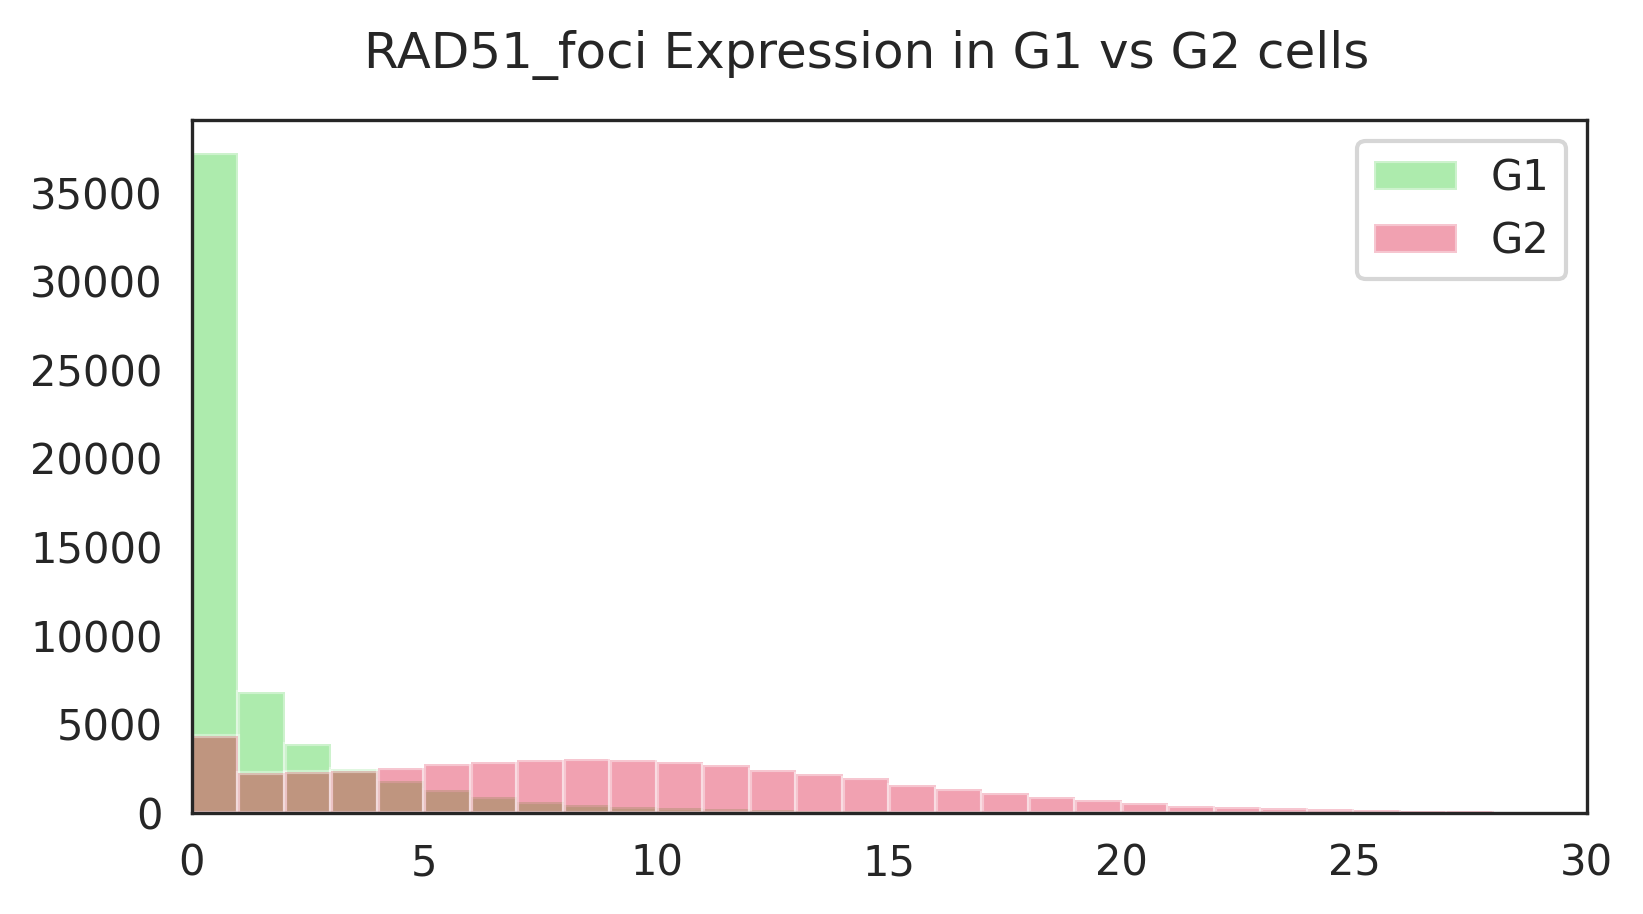

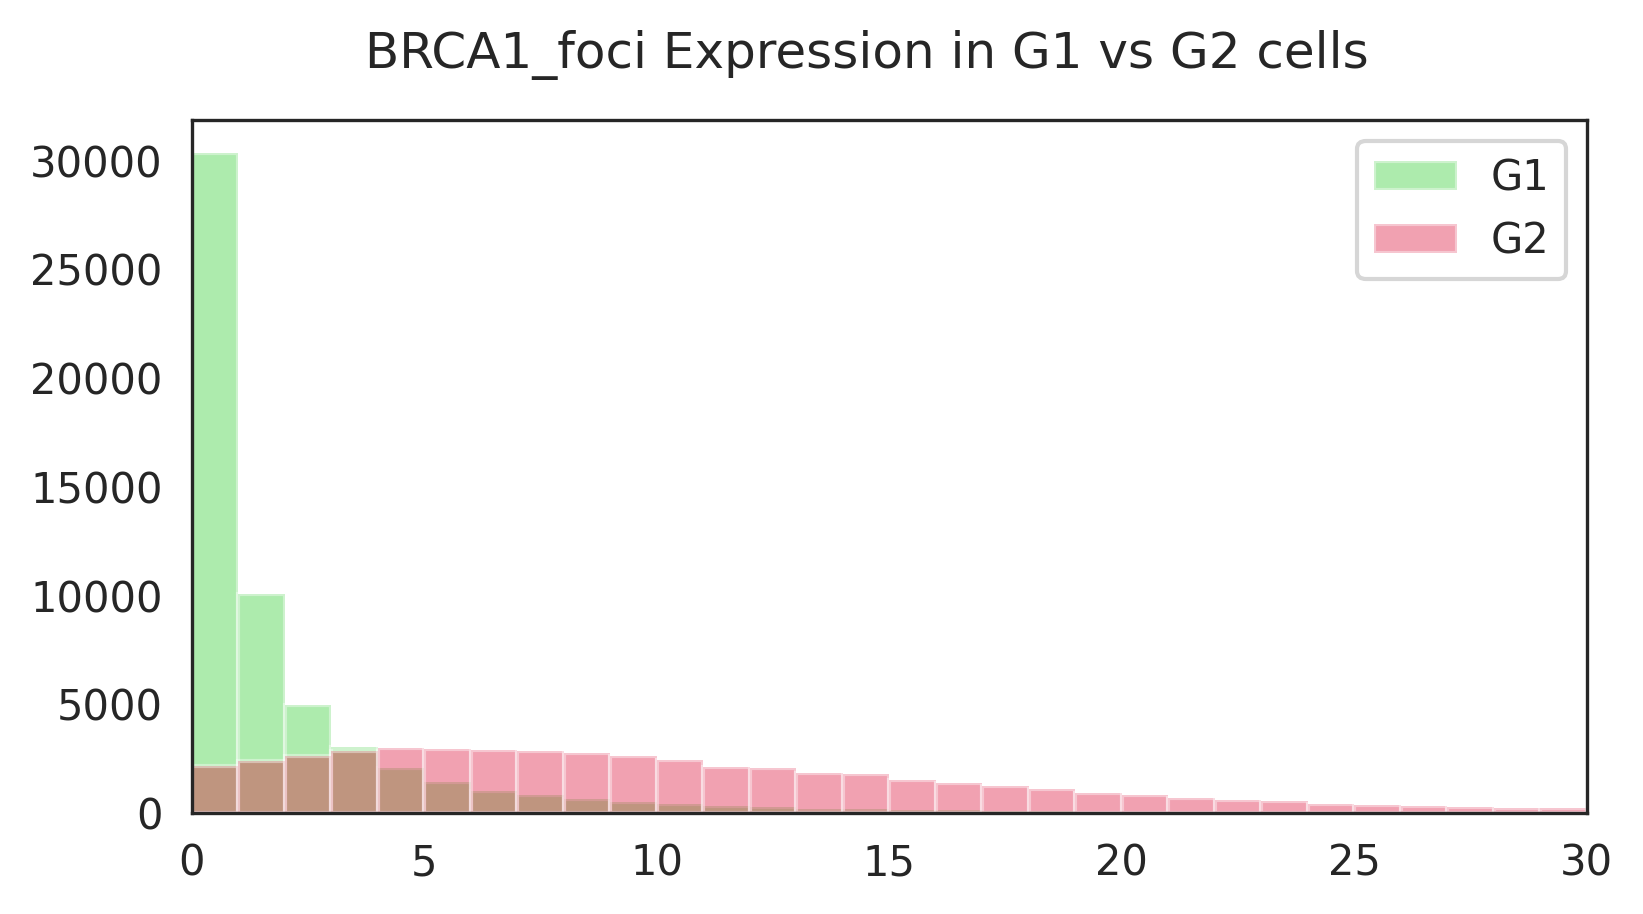

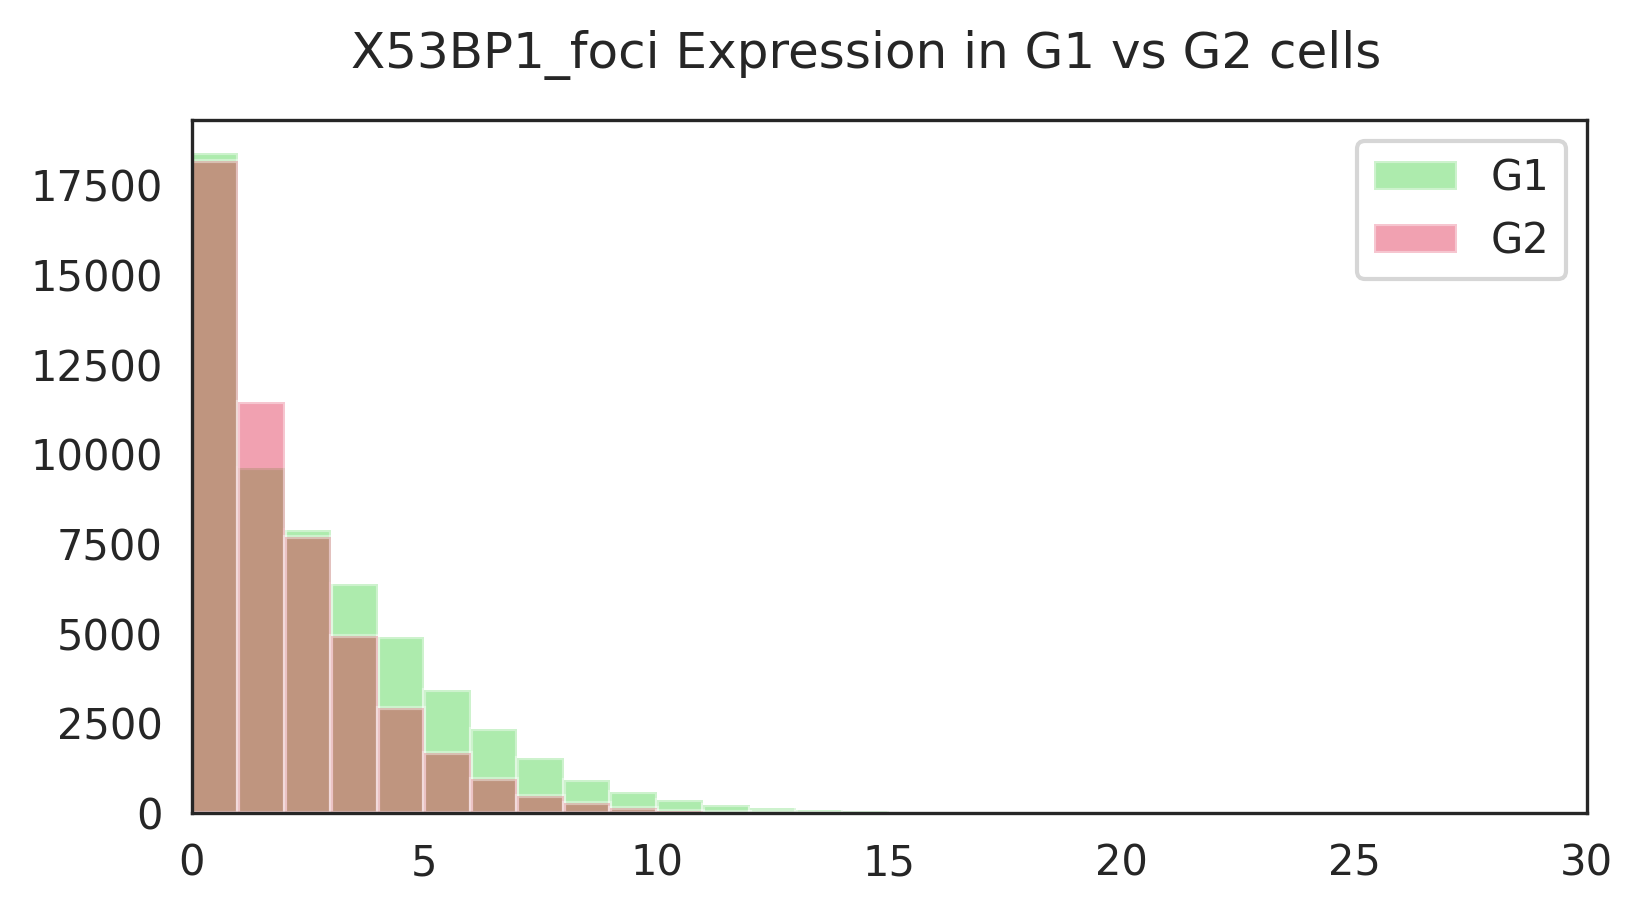

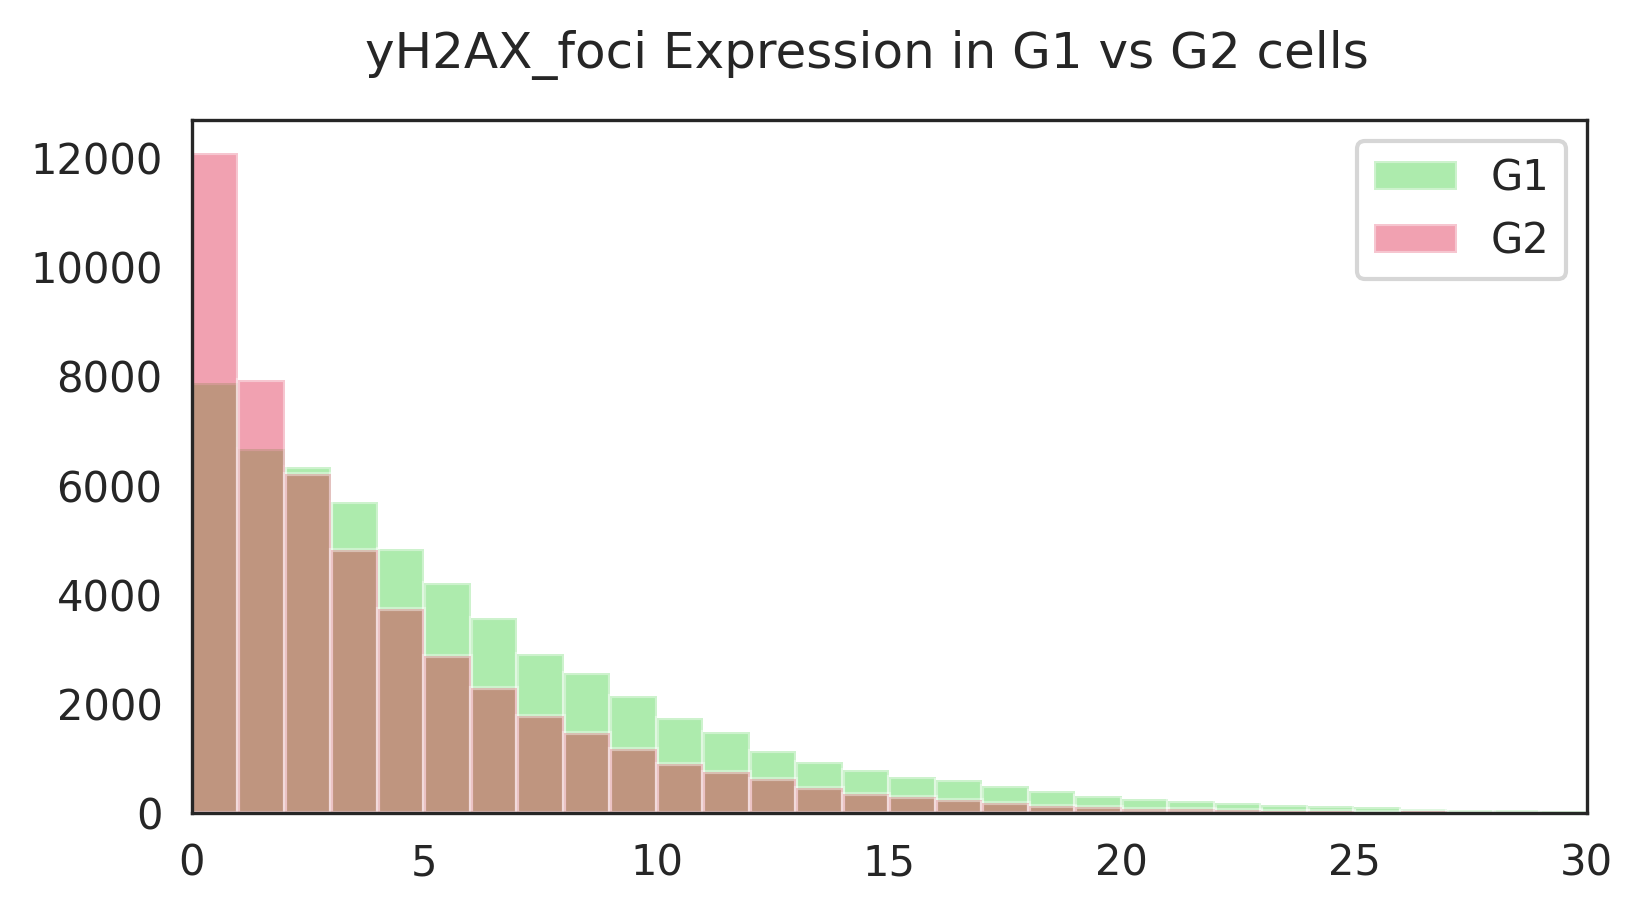

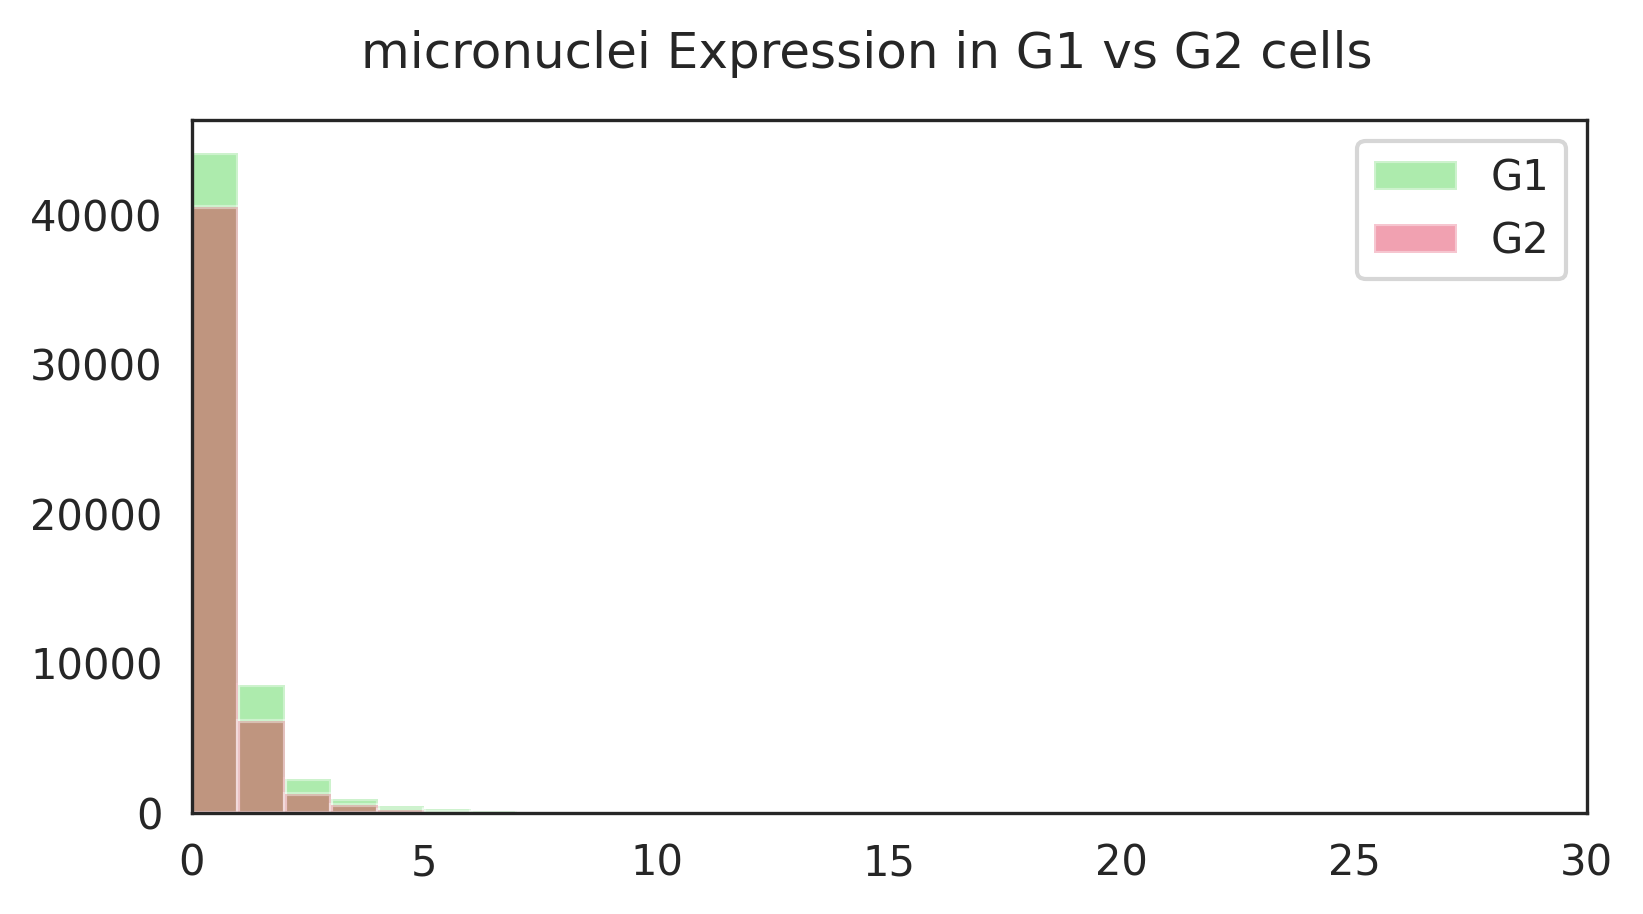

In [13]:
# Visualize the effect of cell cycle on foci expression.
foci = [ "RAD51_foci", "BRCA1_foci", "X53BP1_foci", "yH2AX_foci", "micronuclei"]

bw = 1
for foc in foci:
    G1_df = expr_df[expr_df["cell_cycle"] == 0]
    G1_arr = G1_df[foc].values
    G2_df = expr_df[expr_df["cell_cycle"] == 1]
    G2_arr = G2_df[foc].values

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.hist(G1_arr, color='limegreen', bins=np.arange(int(G1_arr.min()), int(G1_arr.max())+1+bw, bw), alpha=0.4, label='G1')
    ax.hist(G2_arr, color='crimson', bins=np.arange(int(G2_arr.min()), int(G2_arr.max())+1+bw, bw),  alpha=0.4, label='G2')

    plt.xlim(0, 30)
    ax.legend()
    plt.suptitle(f'{foc} Expression in G1 vs G2 cells')
    plt.show()

del bw, foc

#### Separation by Cell Cycle *Optional*

*   Motivation: In the code snippet above, we show that there seems to be foci expression separation between G1 and G2/S cells. In particular, this is observed for RAD51 and BRCA1 foci expression. Therefor, it may make sense to separate the foci expression analysis for G1 and G2/S cells.
*   The code snippet below splits the expression dataframe based on cell cycle. Simply input the cell cycle of interest to the following statistical analysis.



In [14]:
# Split the expression dataframe based on the 'cell_cycle' column.
split_data = expr_df.groupby('cell_cycle')

# Access the individual groups
G1_df = split_data.get_group(0)
G2_df = split_data.get_group(1)

# G1_df.head()

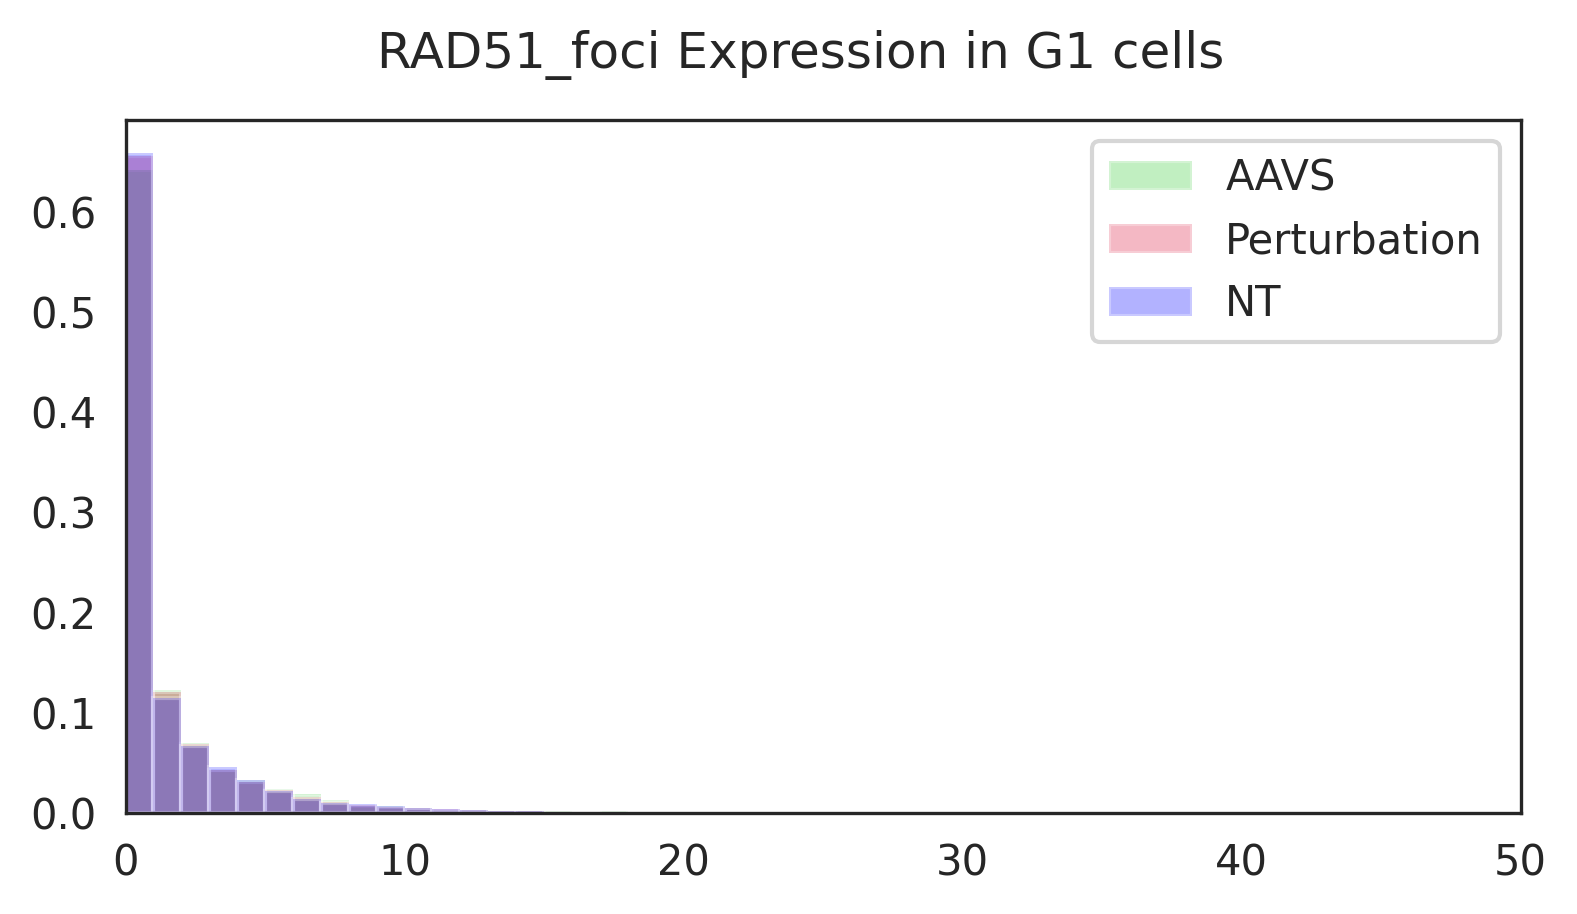

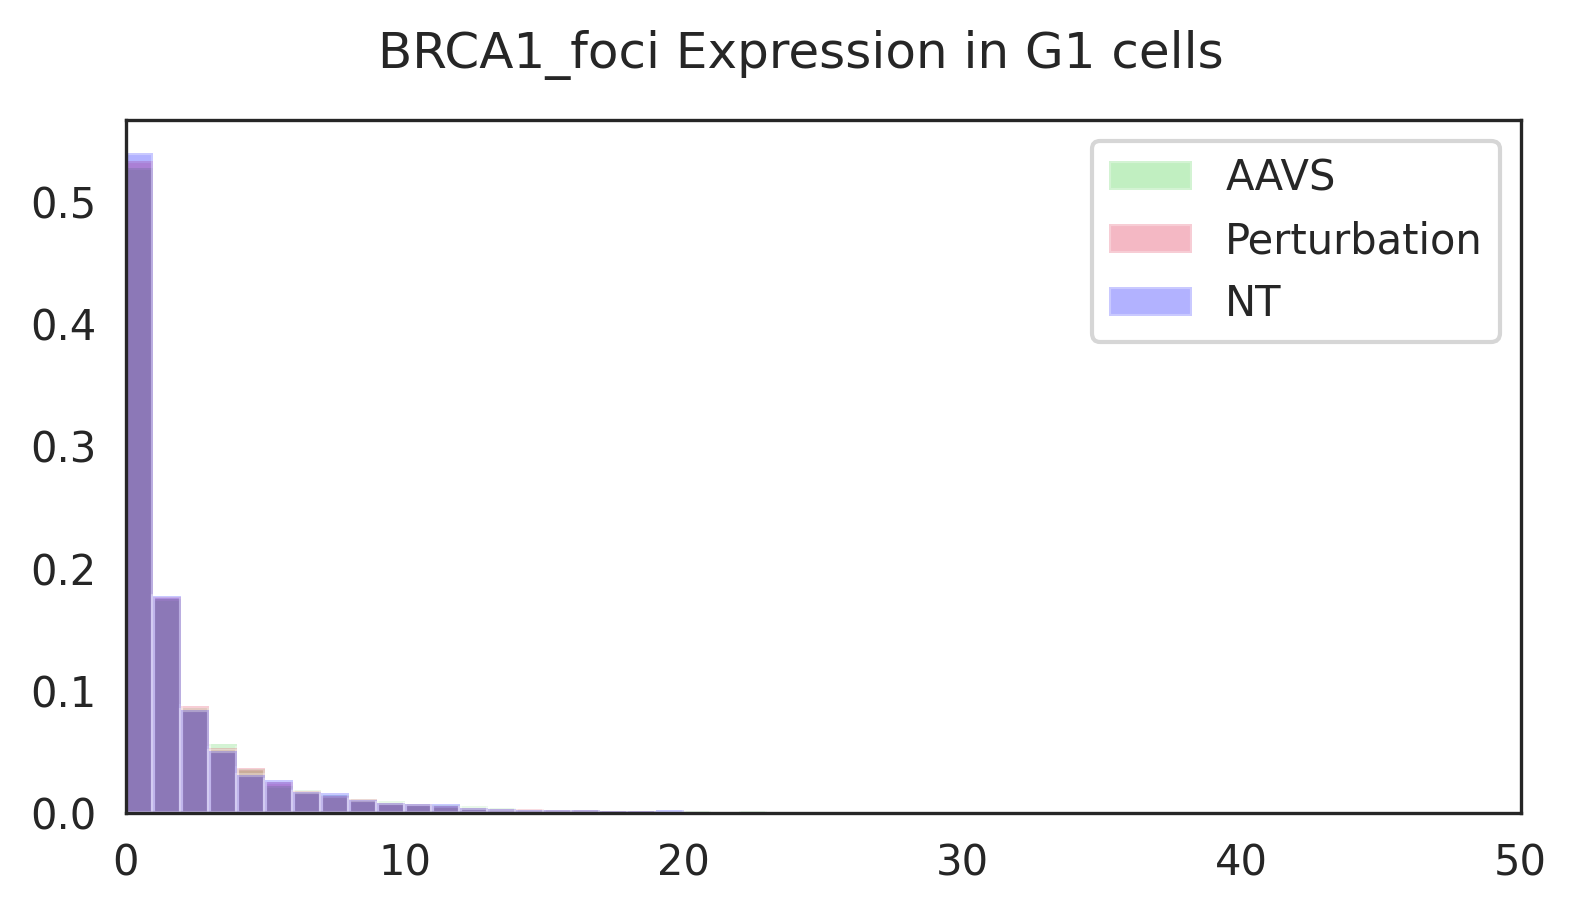

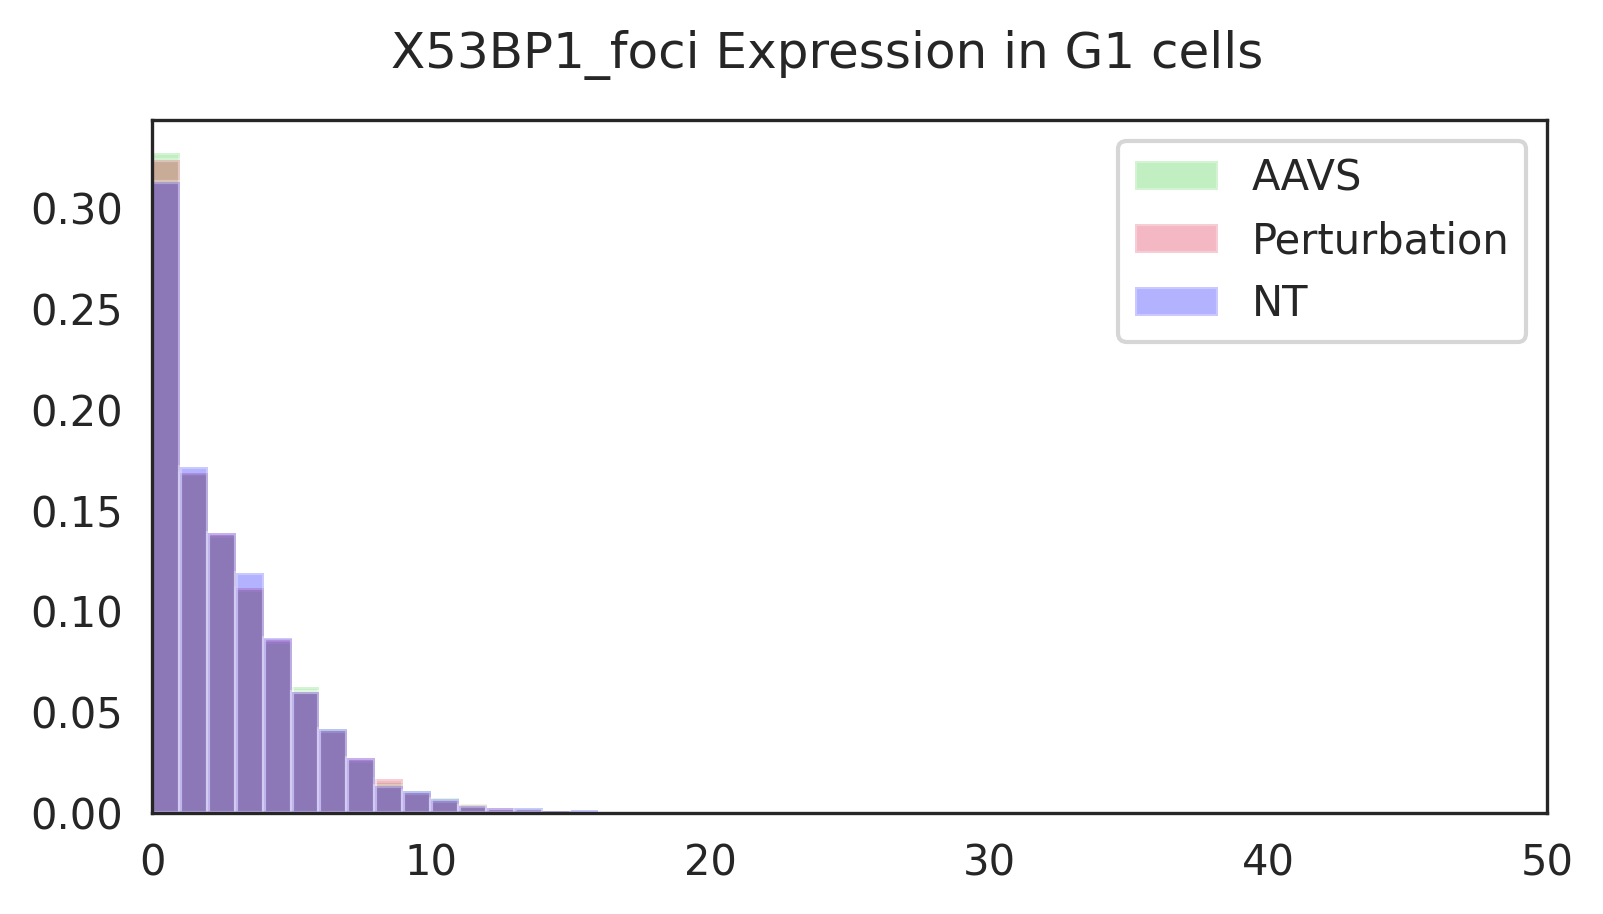

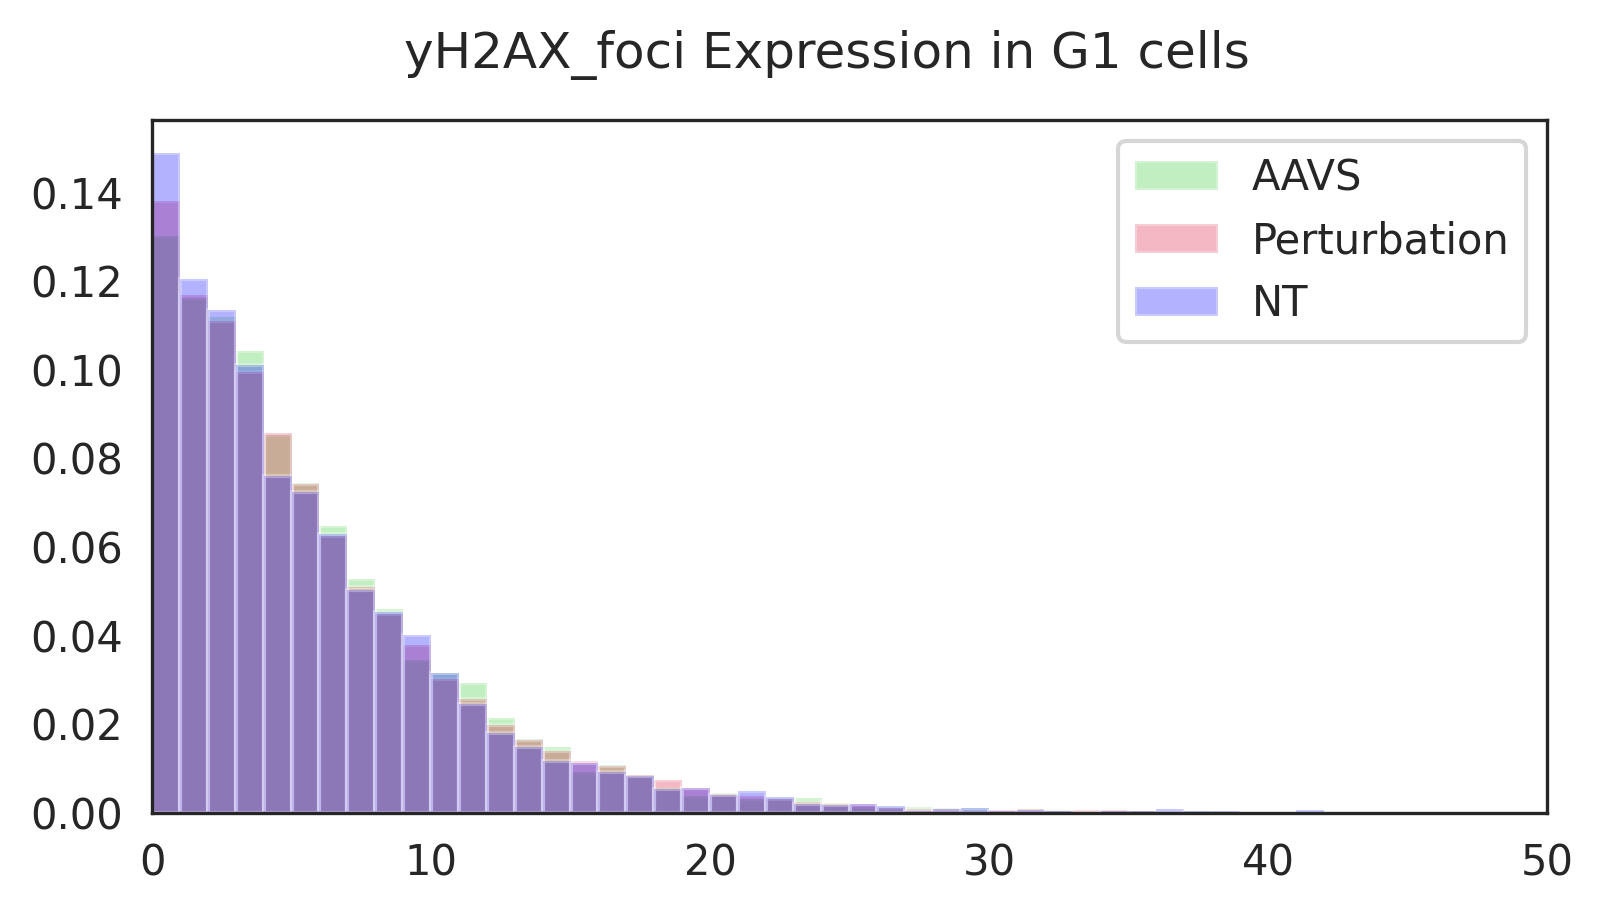

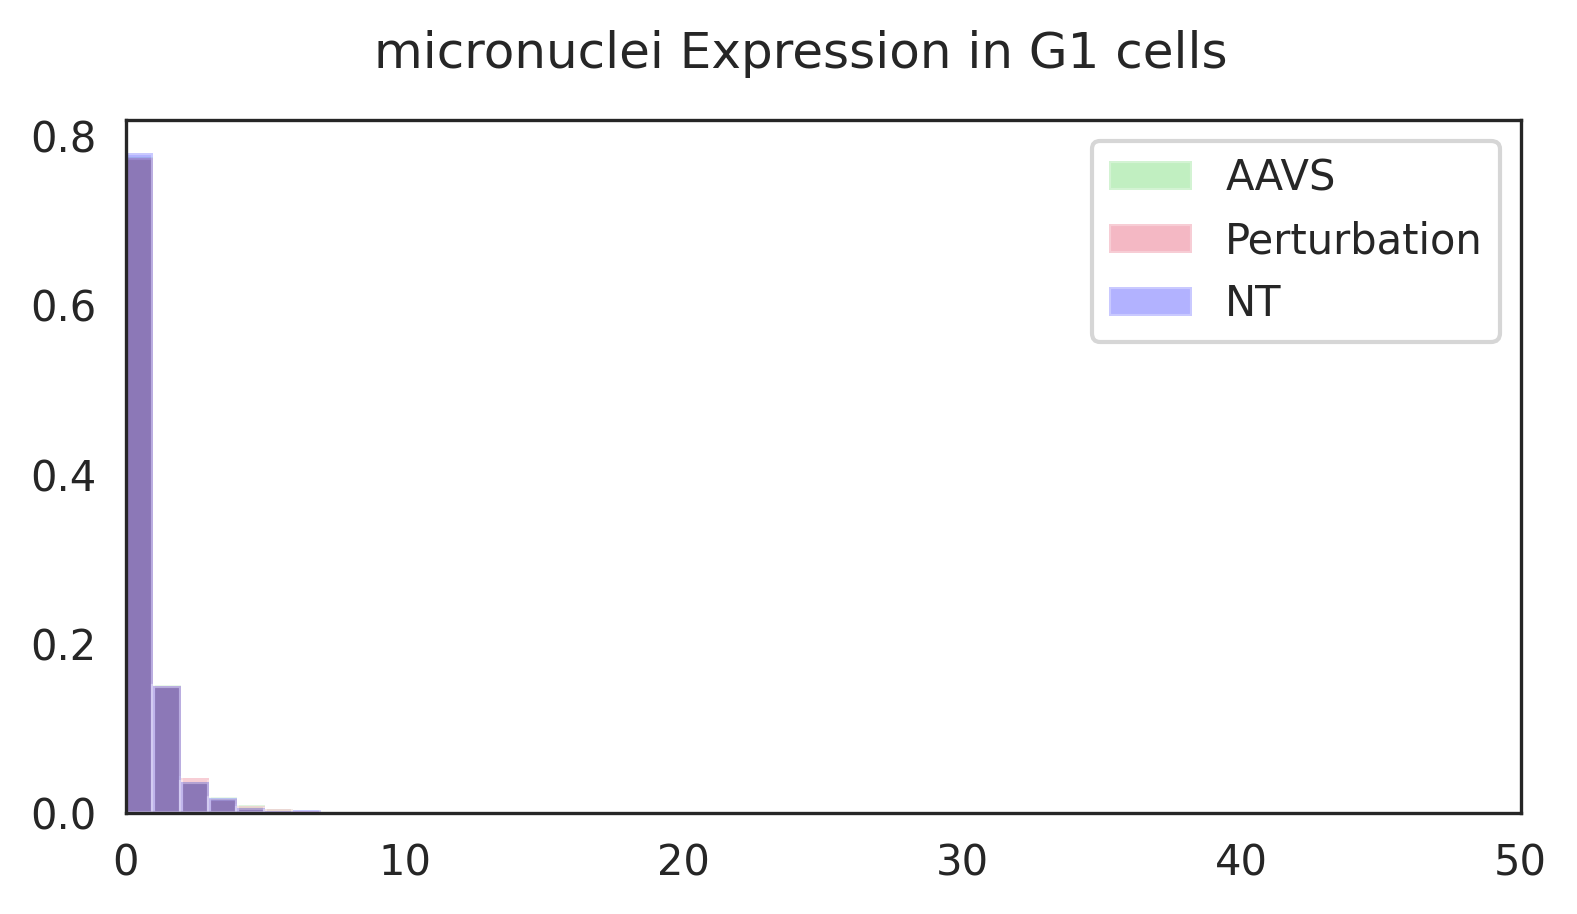

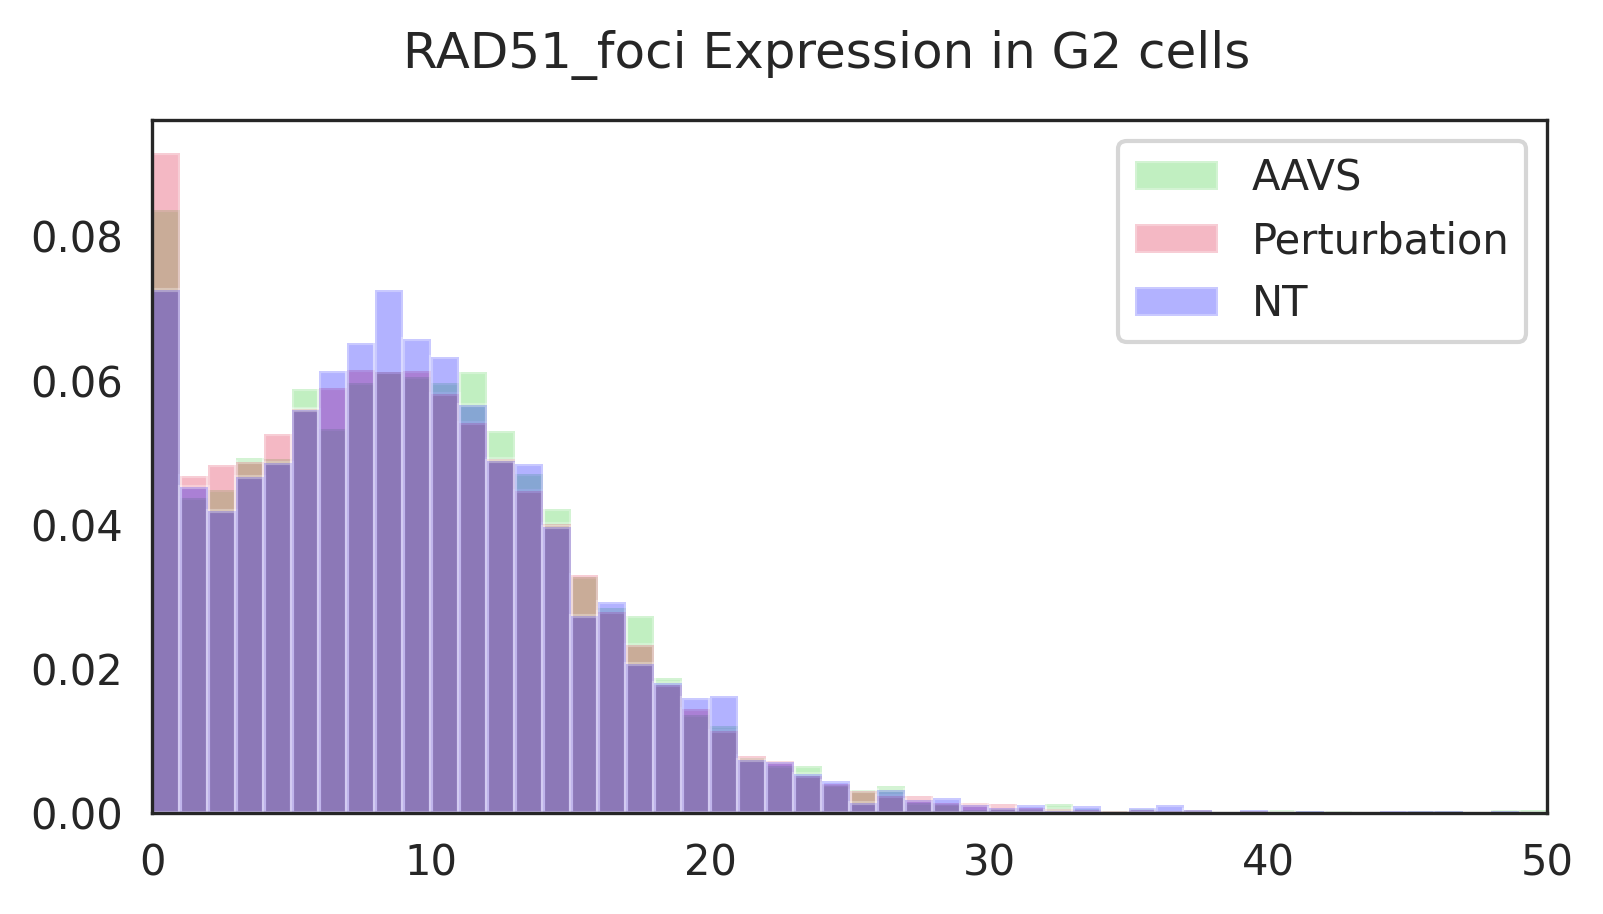

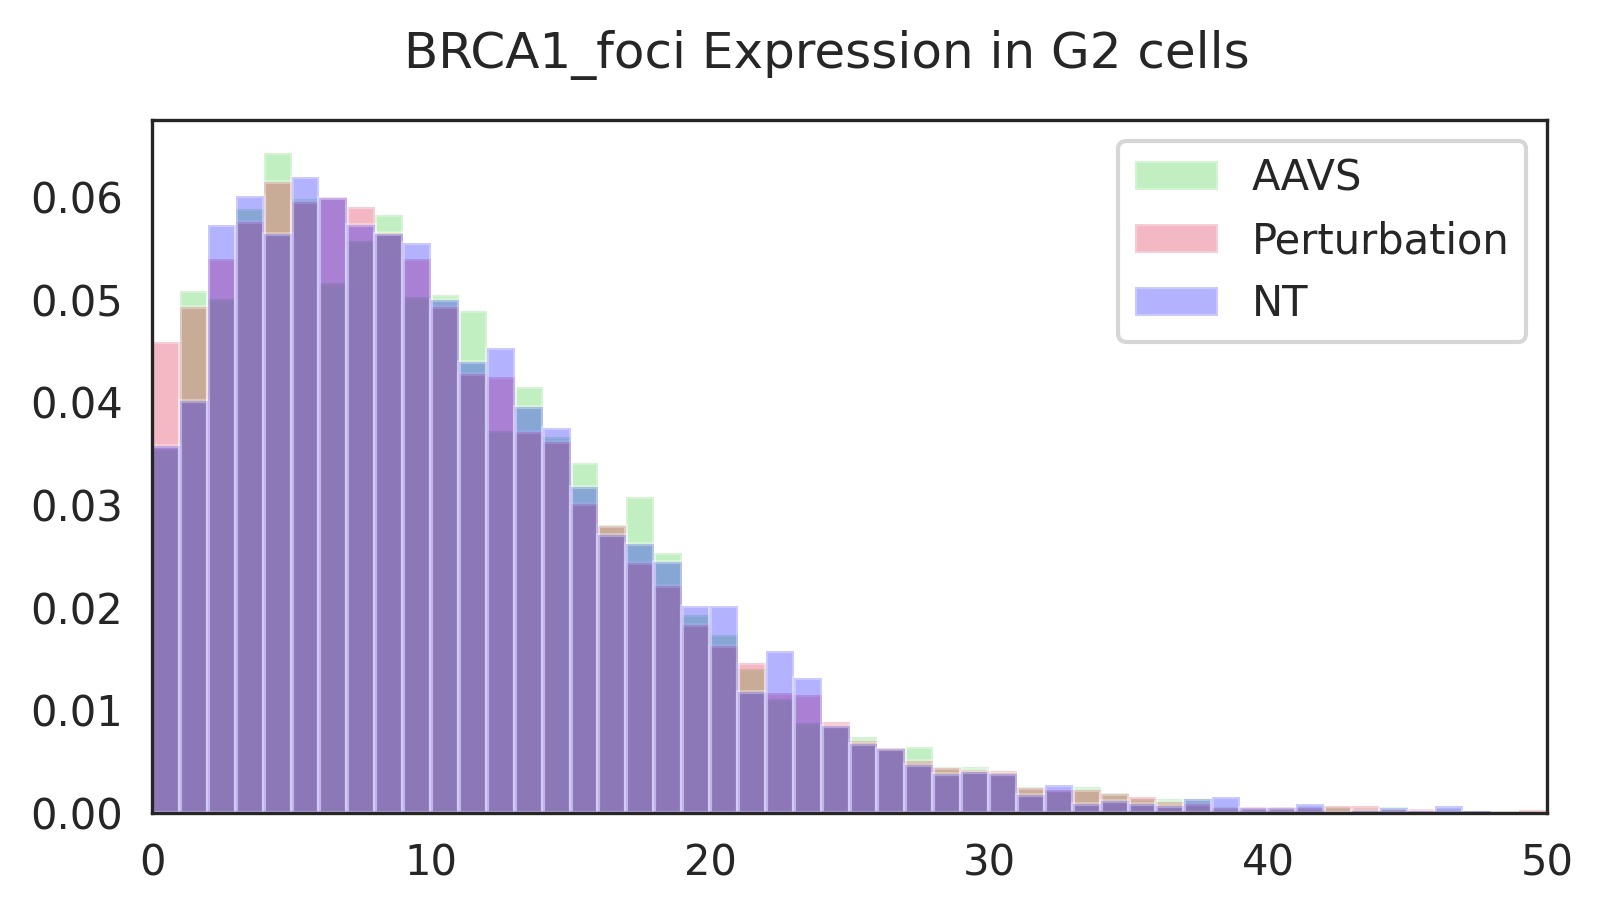

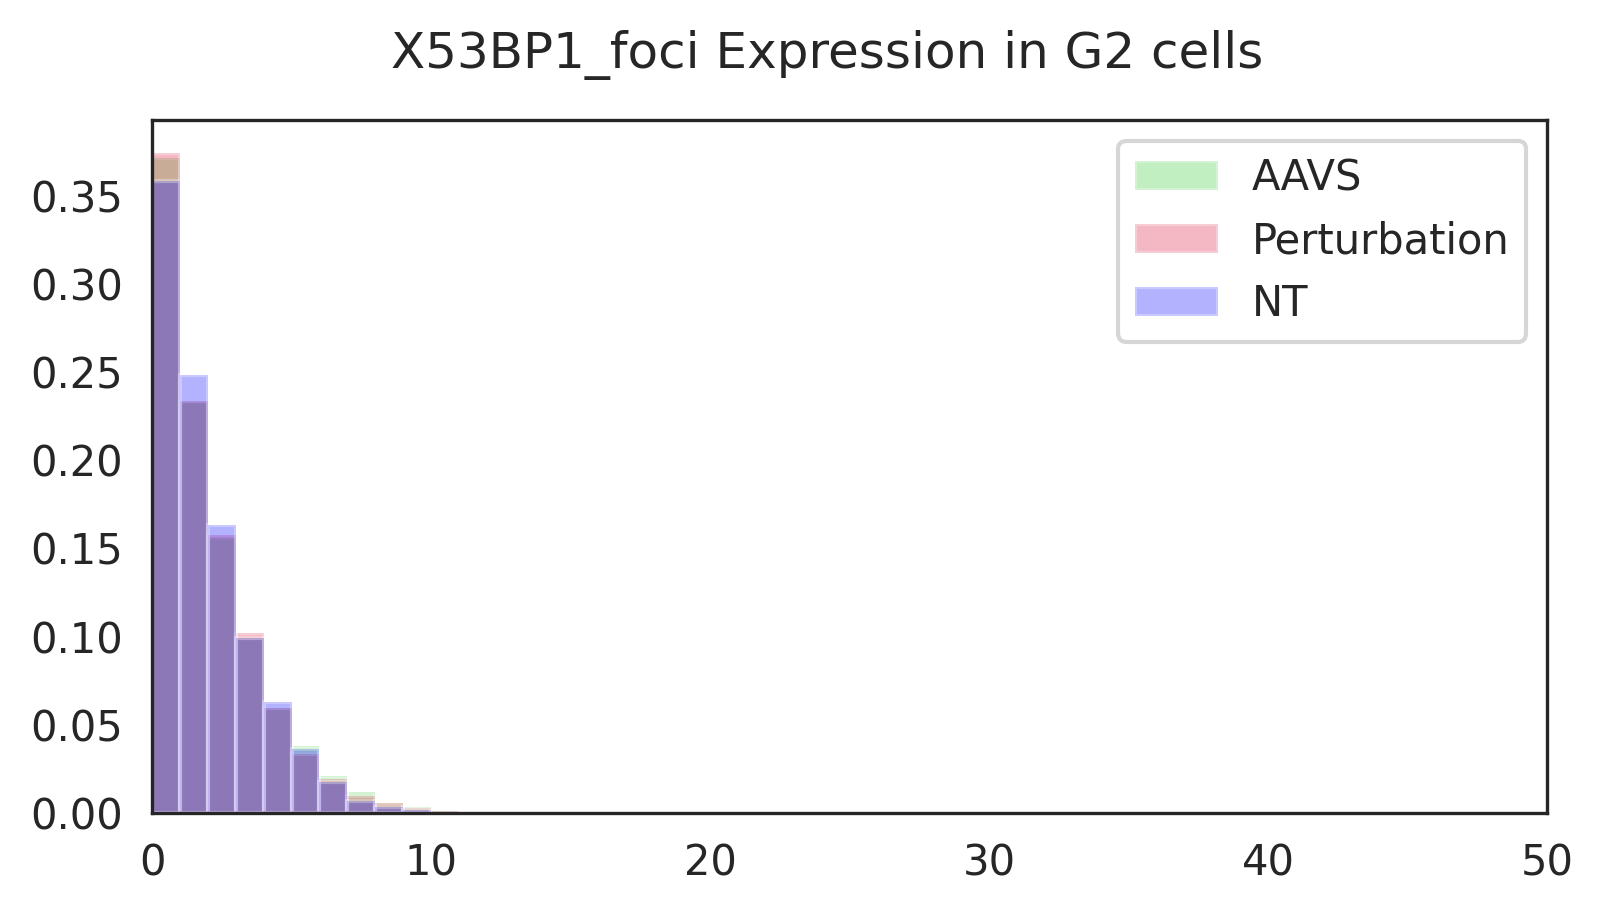

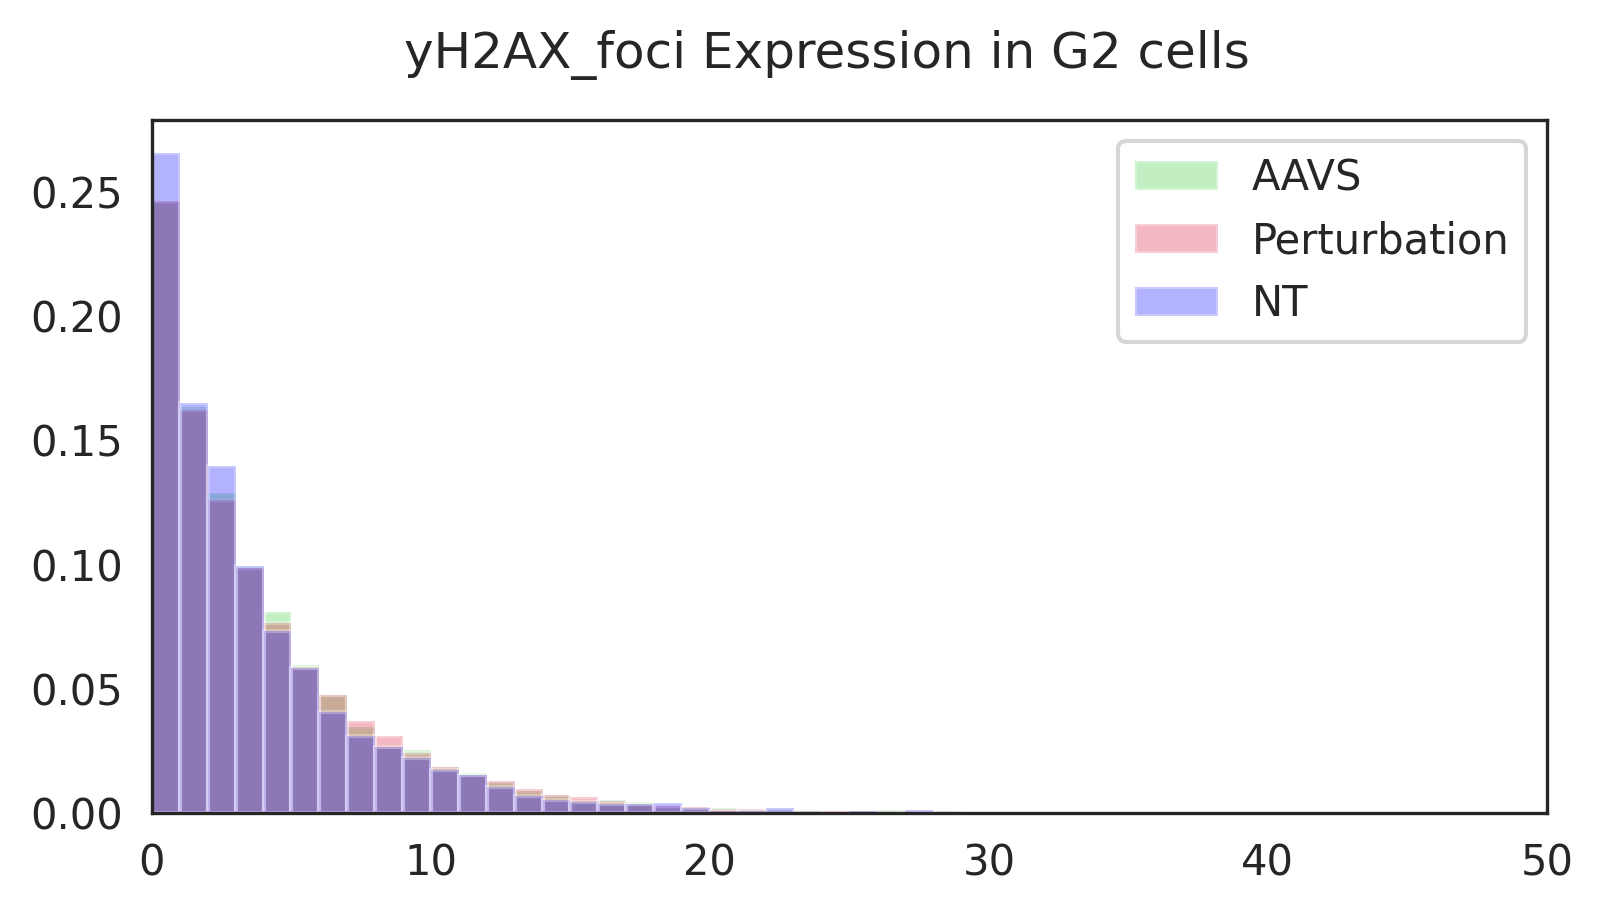

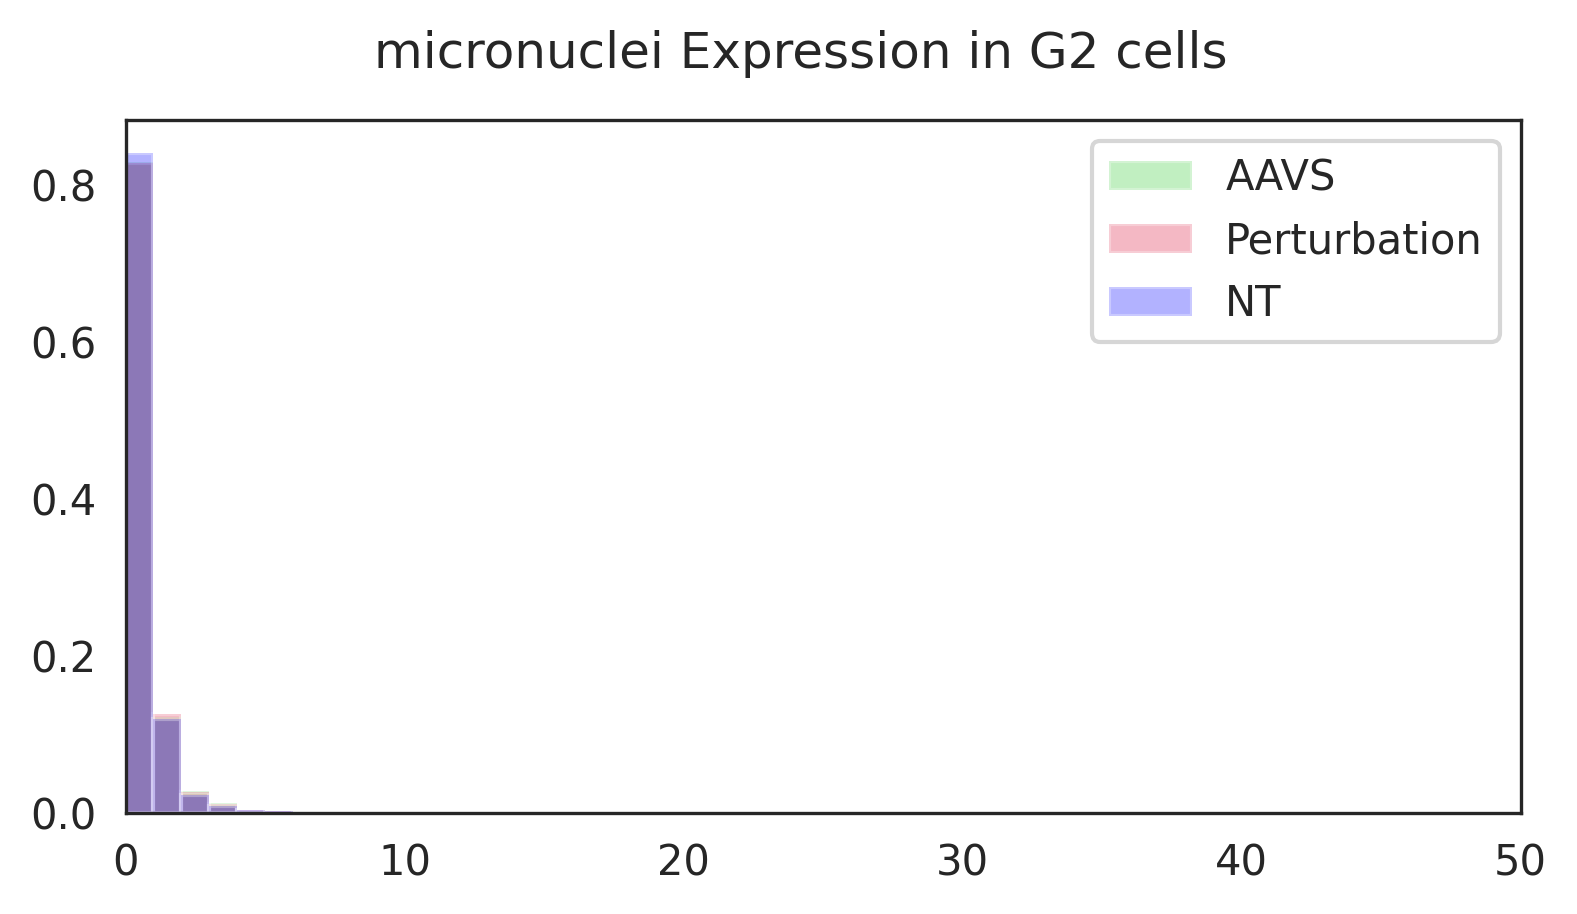

In [15]:
# Visualize the foci expression for G1 and G2/S cells, colored by guide type.
for foc in foci:
    NT_arr, AAVS_arr, Per_arr = get_array(foc, G1_df)

    fig, ax = plt.subplots(figsize=(6, 3))
    bw = 1

    # Histograms are normalized by AUC as sample size are different. If we want actual frequencies remove density = True.
    ax.hist(AAVS_arr, color='limegreen', density = True, bins=np.arange(int(AAVS_arr.min()), int(AAVS_arr.max())+1+bw, bw), alpha=0.3, label='AAVS')
    ax.hist(Per_arr, color='crimson', density = True, bins=np.arange(int(Per_arr.min()), int(Per_arr.max())+1+bw, bw), alpha=0.3, label='Perturbation')
    ax.hist(NT_arr, color='blue', density = True, bins=np.arange(int(NT_arr.min()), int(NT_arr.max())+1+bw, bw), alpha=0.3, label='NT')

    plt.xlim(0, 50)
    ax.legend()
    plt.suptitle(f'{foc} Expression in G1 cells')
    plt.show()

del bw, foc

for foc in foci:
    NT_arr, AAVS_arr, Per_arr = get_array(foc, G2_df)

    fig, ax = plt.subplots(figsize=(6, 3))
    bw = 1

    ax.hist(AAVS_arr, color='limegreen', density = True, bins=np.arange(int(AAVS_arr.min()), int(AAVS_arr.max())+1+bw, bw), alpha=0.3, label='AAVS')
    ax.hist(Per_arr, color='crimson', density = True, bins=np.arange(int(Per_arr.min()), int(Per_arr.max())+1+bw, bw), alpha=0.3, label='Perturbation')
    ax.hist(NT_arr, color='blue', density = True, bins=np.arange(int(NT_arr.min()), int(NT_arr.max())+1+bw, bw), alpha=0.3, label='NT')

    plt.xlim(0, 50)
    ax.legend()
    plt.suptitle(f'{foc} Expression in G2 cells')
    plt.show()

del bw, foc

#### Conducting Two-Sample KS Test Compute Wasserstein Distance
The following loop iterates through the foci (feature) list and for each foci *i*, the loop iterates through the perturbation list and for each perturbation *j*, computes:

*   The Two-Sample KS Test Statistic of foci *i* expression of control (NT or AAVS1 or combined) population v.s. perturbation *j* population.
*   The Two-Sample KS Test p-value of foci *i* expression of control (NT or AAVS1 or combined) population v.s. perturbation *j* population. The p-value is FDR-adjusted using the Benjamini-Hochberg Procedure.
*   The Wasserstein Distance between foci *i* expression of control (NT or AAVS1 or combined) population and perturbation *j* population.

It is possible to integrate the MWU function into this loop. The loop outputs three dataframes containning the three different values it computes. The dataframes are foci (rows) by perturbations (columns). ie. The *i*th row and *j*th column of the foci_by_gene_p dataframe contains the Two-Sample KS FDR-Adjusted p-value of foci *i* expression of control v.s. perturbation *j*.

In [16]:
# Define the Foci list and the Perturbation list
foci = ["RAD51_foci", "BRCA1_foci", "X53BP1_foci", "yH2AX_foci", "micronuclei"]

test_perturb_list = AAVS_list + perturb_list # Here, we are testing AAVS1 controls as pseudo-perturbations against non-targeting controls. Can set this as containning strictly perturbations.
perturbations = [] # perturbations is a list containning all guides we are testing against defined control. Here it contains both AAVS1 and perturbation guides.
for per in test_perturb_list:
    perturbations.append(per)

# Initiate dataframes to store KS p-values, KS test statistics and Wasserstein distances.
foci_by_gene_p = pd.DataFrame(columns=perturbations)
foci_by_gene_stat = pd.DataFrame(columns=perturbations)
foci_by_gene_dist = pd.DataFrame(columns=perturbations)

# Nested loop iterating through foci and perturbations.
for idx, i in enumerate(foci):
    p_values = []
    KS_stats = []
    WS_dist = []

    for jdx, j in enumerate(test_perturb_list):
        dataframe = guide_df("targeting", str(j), expr_df) # Optionally can analyze G1 and G2/S separately, additonally may choose to define a different control (here we used non-targeting controls).
        dataframe["guide"] = dataframe["guide"].apply(lambda x: binary(x, str(j)))

        KS_stat, KS_p = KS(i, dataframe)
        WS_d = WS(i, dataframe)

        p_values.append(KS_p)
        KS_stats.append(KS_stat)
        WS_dist.append(WS_d)

    foci_by_gene_p.loc[str(i)] = smt.multipletests(p_values, method="fdr_bh")[1] # Implementing the Benjamini-Hochberg FDR correction
    foci_by_gene_stat.loc[str(i)] = KS_stats
    foci_by_gene_dist.loc[str(i)] = WS_dist

del idx, i, jdx, j

# foci_by_gene_p.head()
# foci_by_gene_stat.head()
# foci_by_gene_dist.head()

In [17]:
# # Write the dataframes into CSV files
# foci_by_gene_p.to_csv('foci_by_gene_p.csv', index=False)
# foci_by_gene_stat.to_csv('foci_by_gene_stat.csv', index=False)
# foci_by_gene_dist.to_csv('foci_by_gene_dist.csv', index=False)

In [18]:
# For each perturbation guide, find all KS-significant foci (p-value < 0.05), store the significant foci, its associated p-value and test statistic into a dictionary.
gene_foci_dict = {} # Initiate empty dictionary to store values in nested list: ie. 'guide.xxx': [['significant_foci_A', p-value, test statistic], ['significant_foci_B', p-value, test statistic], ...]

for jdx, j in enumerate(test_perturb_list):
    gene_foci_dict[str(j)] = []

    for idx, i in enumerate(foci):
        dataframe = guide_df("targeting", str(j), expr_df)
        dataframe["guide"] = dataframe["guide"].apply(lambda x: binary(x, str(j)))

        if foci_by_gene_p.loc[str(i), str(j)] < 0.05:
            gene_foci_dict[str(j)].append([str(i), foci_by_gene_p.loc[str(i), str(j)], foci_by_gene_stat.loc[str(i), str(j)]])

# print(gene_foci_dict)

In [19]:
# # Write the dictionary into a CSV file
# def write_dict_to_csv(dictionary, file_path):
#     with open(file_path, 'w', newline='') as csvfile:
#         writer = csv.DictWriter(csvfile, fieldnames=dictionary.keys())
#         writer.writeheader()
#         writer.writerow(dictionary)
#     print("Dictionary successfully written to CSV file.")

# write_dict_to_csv(gene_foci_dict, 'gene_foci_dict.csv') # May change the file path and name.

#### KS Test Statistic Visualization

Text(0.5, 1.0, 'KS Summary of 275 Unique Perturbations')

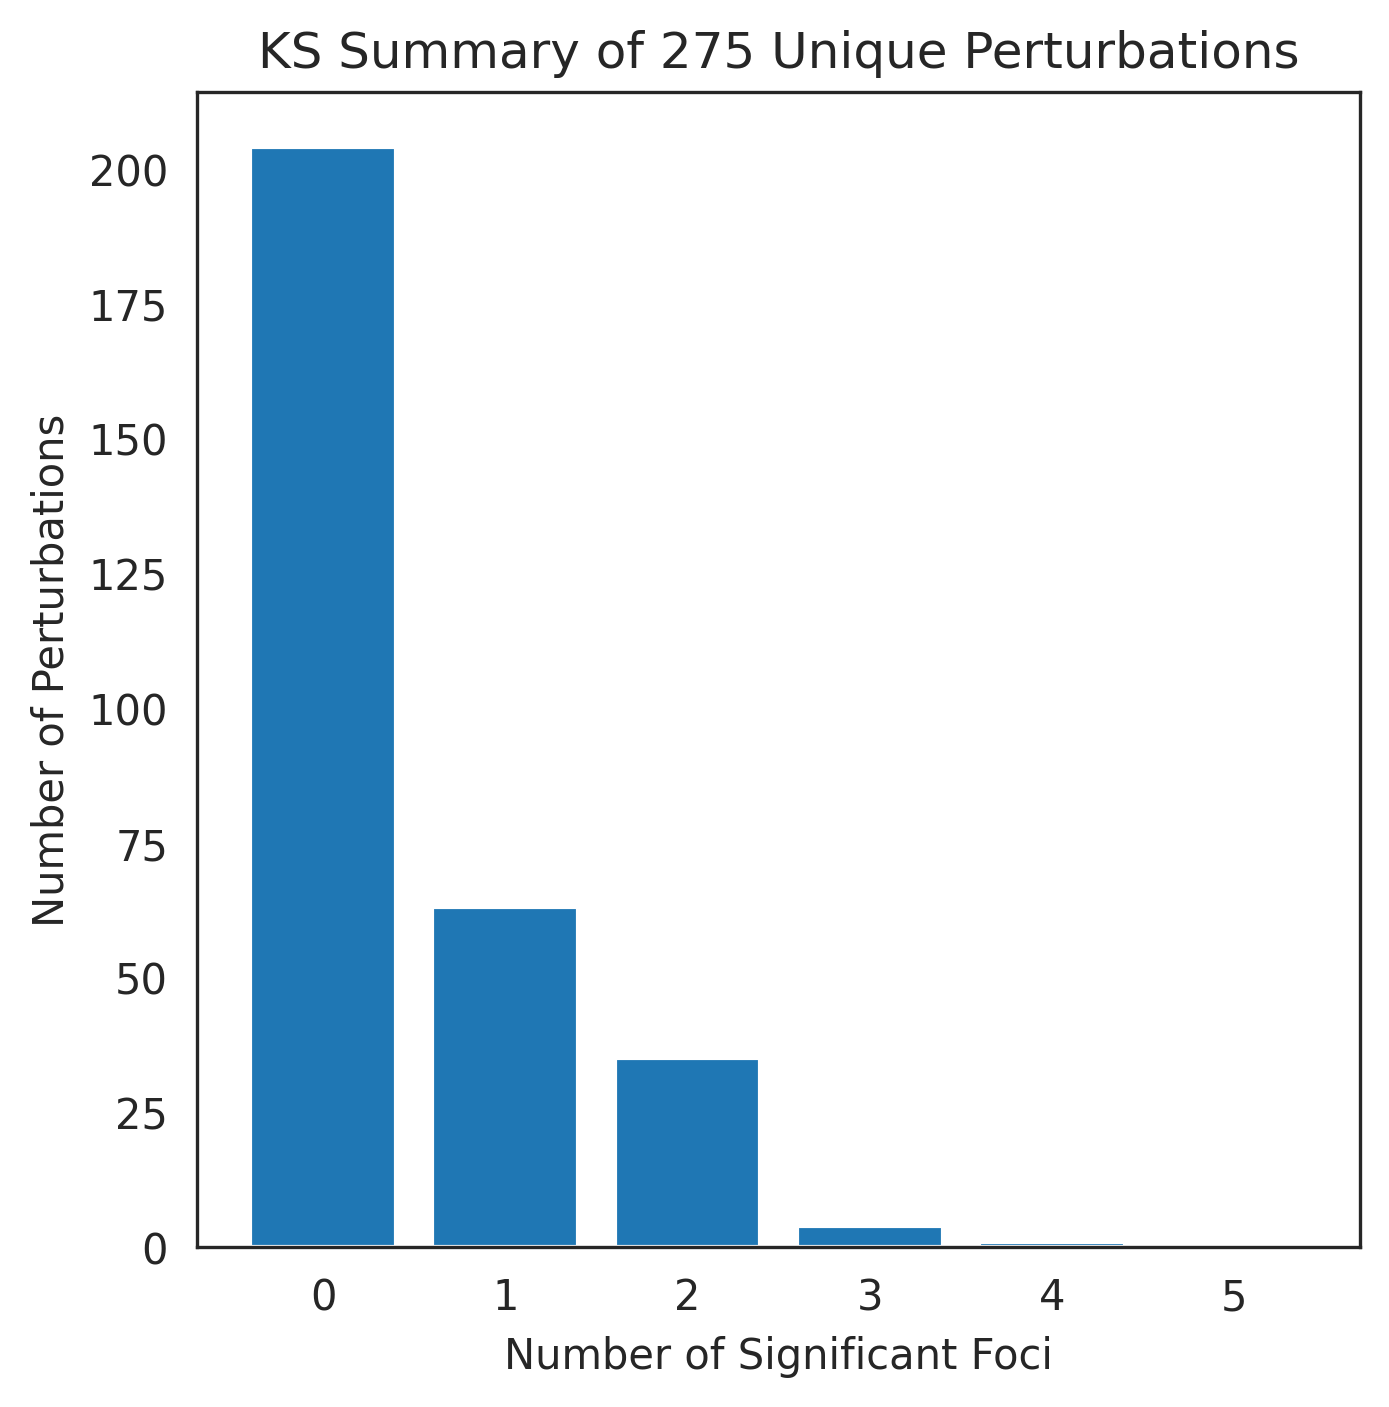

In [20]:
# Visualize the number of perturbations for significant foci
zero = []
one = []
two = []
three = []
four = []
five = []

for key in gene_foci_dict:
    if len(gene_foci_dict[key]) == 0:
        zero.append(key)
    elif len(gene_foci_dict[key]) == 1:
        one.append(key)
    elif len(gene_foci_dict[key]) == 2:
        two.append(key)
    elif len(gene_foci_dict[key]) == 3:
        three.append(key)
    elif len(gene_foci_dict[key]) == 4:
        four.append(key)
    else:
        five.append(key)

plt.bar(["0", "1","2","3","4","5"], [len(zero), len(one), len(two),len(three),len(four), len(five)])
plt.xlabel("Number of Significant Foci")
plt.ylabel("Number of Perturbations")
plt.title("KS Summary of 275 Unique Perturbations")

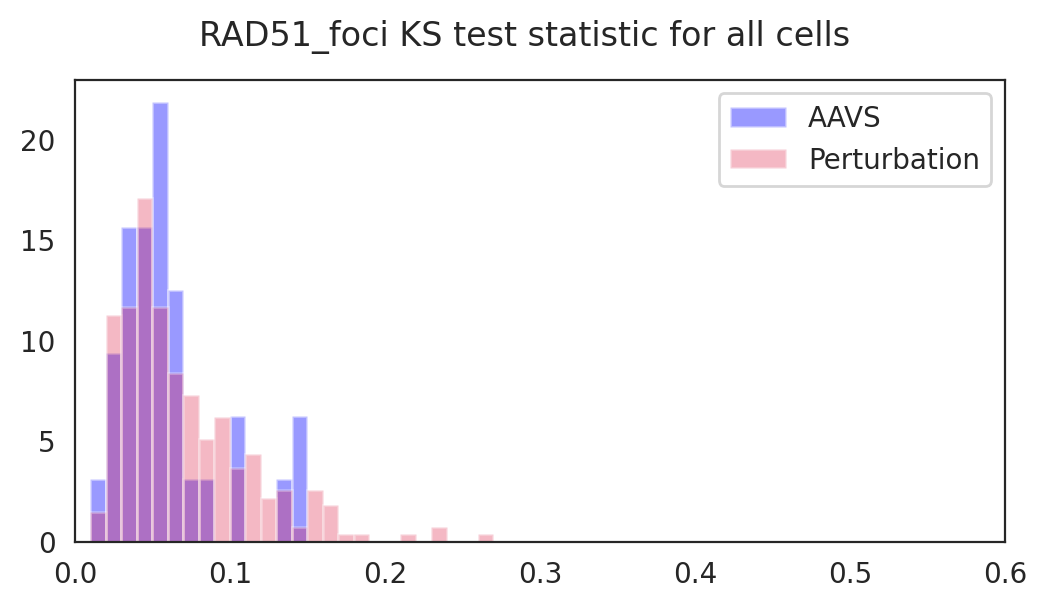

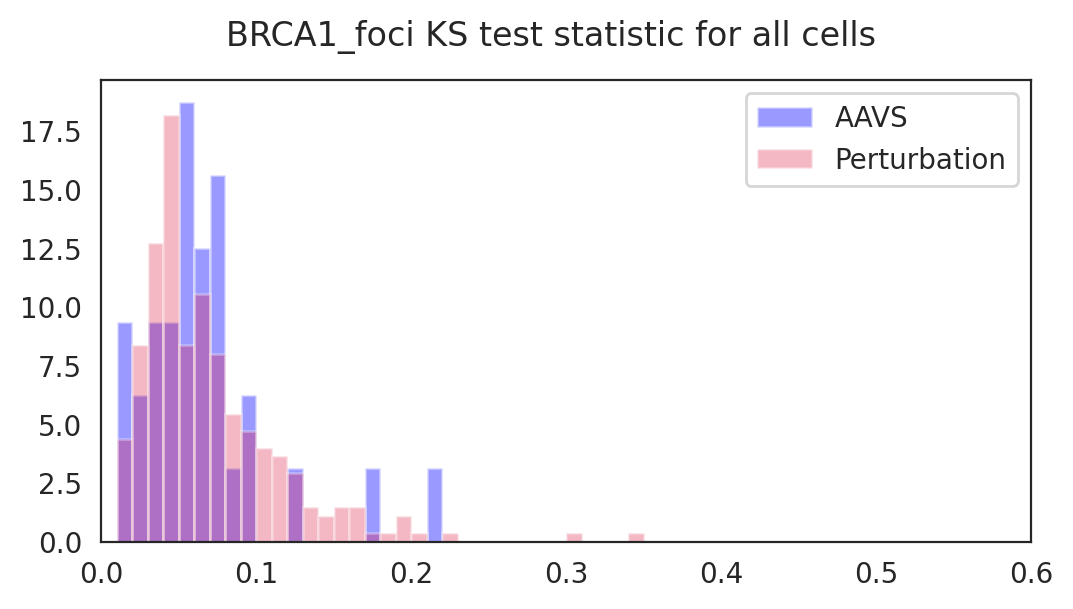

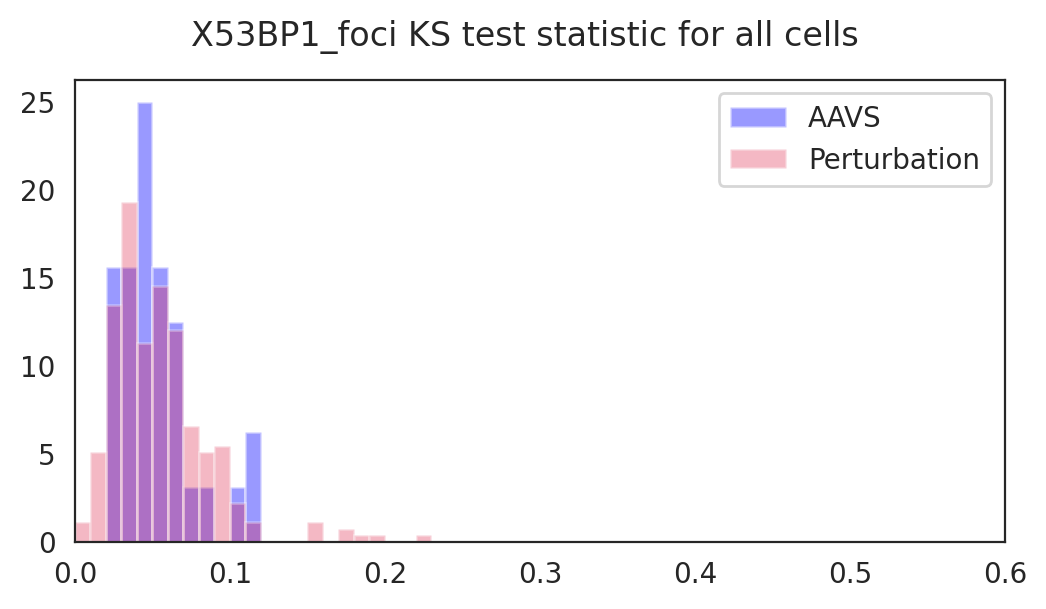

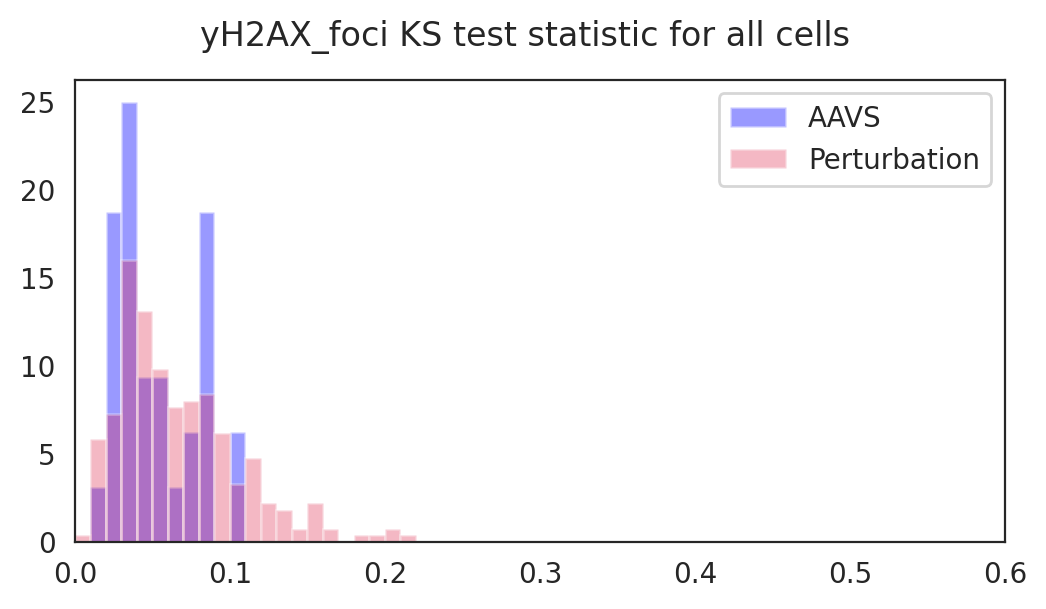

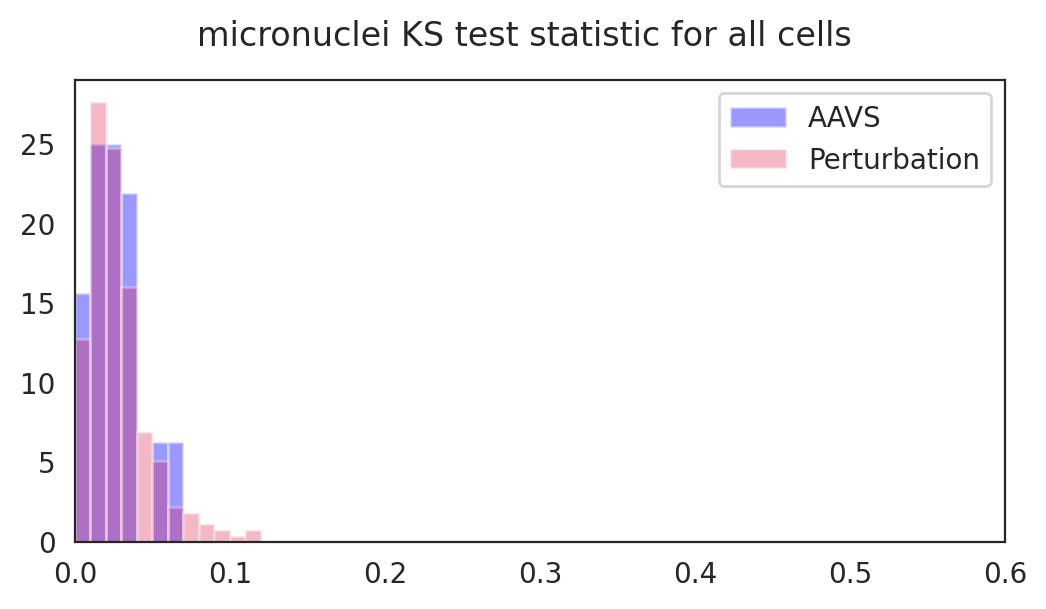

In [21]:
# Visualize KS test statistic distribution across different guide types for expression dataframe of interest

AAVS_guides = []
perturbs_guides = []
NT_guide = []
robust_guides = ["ATR.472", "ATR.151", "ATM.518", "ATM.251", "RAD51D.62", "RAD51D.1", "BRCA1.416", "BRCA2.207", "XRCC3.198", "BARD1.222"] # Known robust guides provided

for column in foci_by_gene_stat.columns:
    if 'AAVS1' in column:
        AAVS_guides.append(column)
    elif "targeting" in column:
        NT_guide.append(column)
    else:
        perturbs_guides.append(column)

NT_arr = []
robust_arr = []
AAVS_arr = []
perturbs_arr = []

for foc in foci:
    AAVS_arr = foci_by_gene_stat.loc[foc, AAVS_guides].values
    perturbs_arr = foci_by_gene_stat.loc[foc, perturbs_guides].values
    NT_arr = foci_by_gene_stat.loc[foc, NT_guide].values
    # robust_arr = foci_by_gene_stat.loc[foc, robust_guides].values

    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
    bw = 0.01

    ax.hist(AAVS_arr, color="blue",density = True, bins=np.arange(int(AAVS_arr.min()), int(AAVS_arr.max())+1+bw, bw), alpha=0.4, label='AAVS')
    ax.hist(perturbs_arr, color='crimson',density = True, bins=np.arange(int(perturbs_arr.min()), int(perturbs_arr.max())+1+bw, bw),alpha=0.3, label='Perturbation')
    # ax.hist(robust_arr, color='yellow', bins=np.arange(int(robust_arr.min()), int(robust_arr.max())+1+bw, bw), alpha=0.3, label='Robust')

    plt.xlim(0, 0.6)
    ax.legend()
    plt.suptitle(f'{foc} KS test statistic for all cells')
    plt.show()

del NT_arr, AAVS_arr, perturbs_arr, perturbs_guides, AAVS_guides

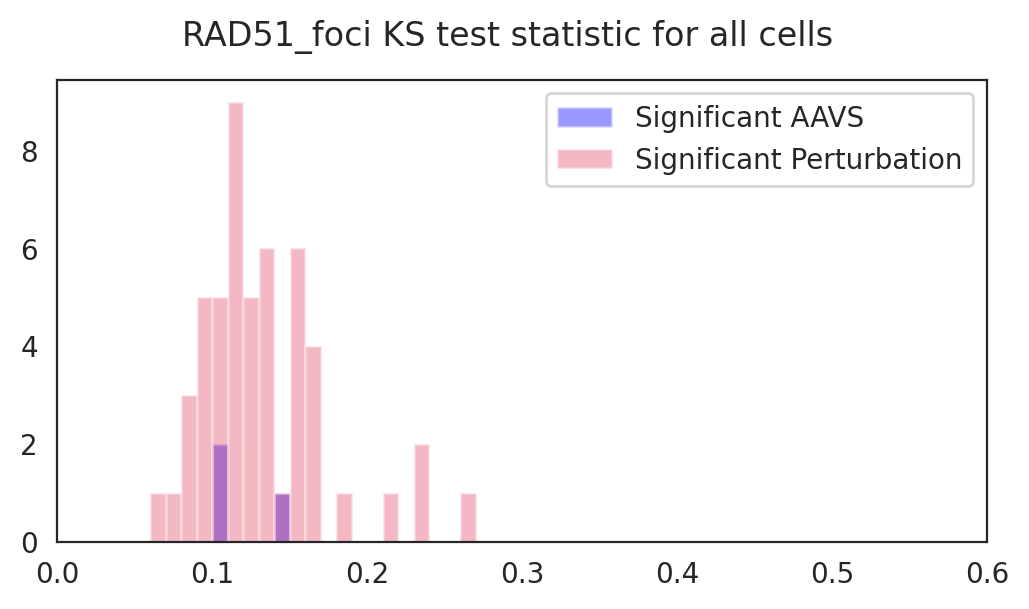

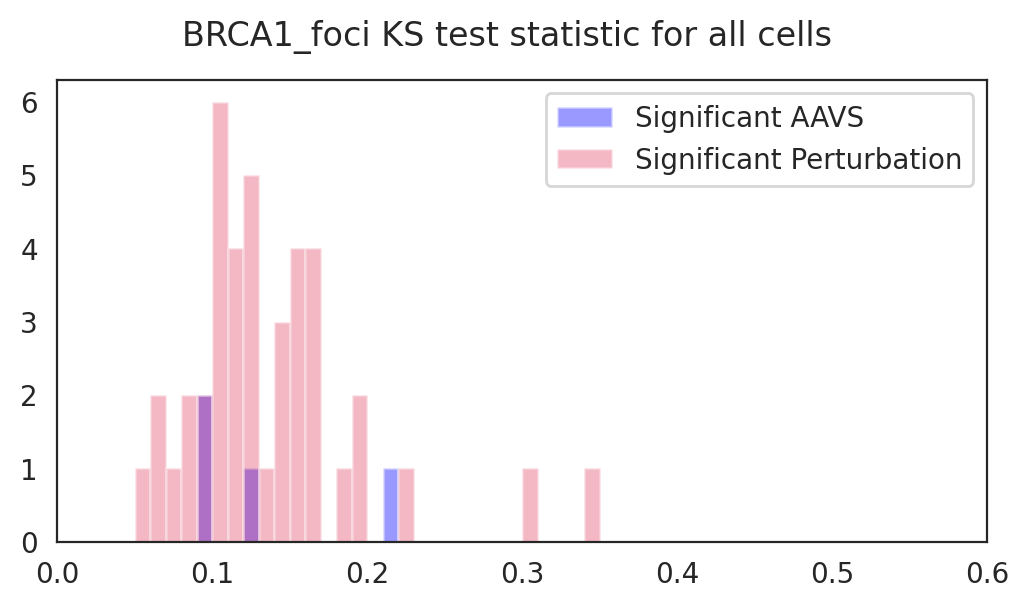

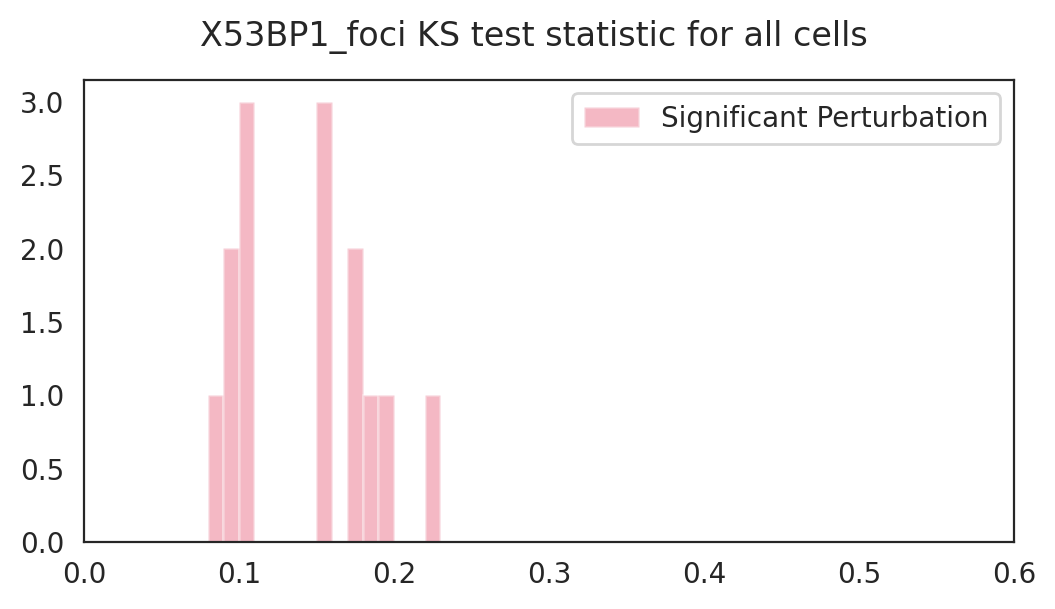

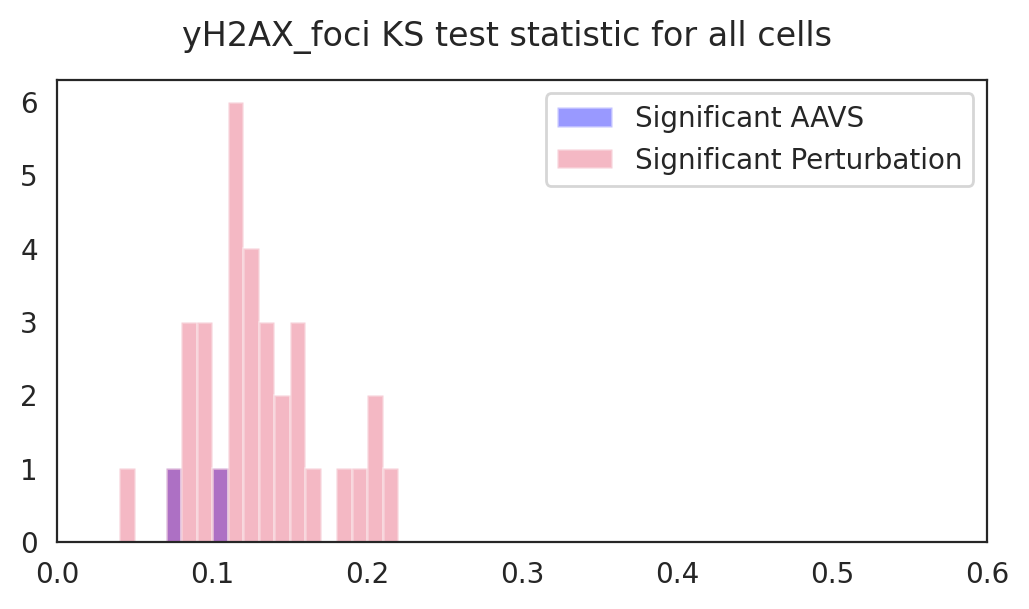

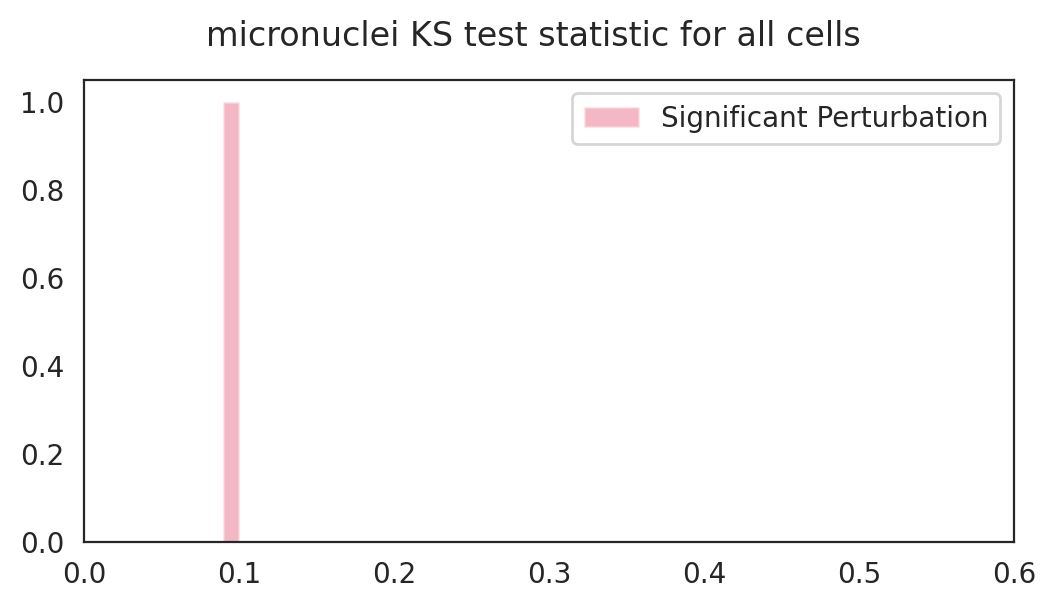

In [22]:
# Visualize KS-significant KS test statistic distribution across different guide types for expression dataframe of interest

for foc in foci:
    foci_sig_per = find_keys_with_foci(foc, gene_foci_dict)

    AAVS_guides = []
    perturbs_guides = []
    # Robust_guides = []

    # Loop through each element in foci_sig_per
    for guide in foci_sig_per:
        if "AAVS1" in guide:
            AAVS_guides.append(guide)
        # elif guide in robust_guides:
            # Robust_guides.append(guide)
            # perturbs_guides.append(guide)  # Add the guide to perturbs_guides as well
        else:
            perturbs_guides.append(guide)

    AAVS_arr = foci_by_gene_stat.loc[foc, AAVS_guides].values
    perturbs_arr = foci_by_gene_stat.loc[foc, perturbs_guides].values
    # robust_arr = foci_by_gene_stat.loc[foc, Robust_guides].values

    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
    bw = 0.01

    if len(AAVS_arr) > 0:
        ax.hist(AAVS_arr, color="blue", bins=np.arange(int(AAVS_arr.min()), int(AAVS_arr.max())+1+bw, bw), alpha=0.4, label='Significant AAVS') #density = True,

    if len(perturbs_arr) > 0:
        ax.hist(perturbs_arr, color='crimson', bins=np.arange(int(perturbs_arr.min()), int(perturbs_arr.max())+1+bw, bw),alpha=0.3, label='Significant Perturbation')

    # if len(robust_arr) > 0:
         # ax.hist(robust_arr, color='yellow', bins=np.arange(int(robust_arr.min()), int(robust_arr.max())+1+bw, bw), alpha=0.3, label='Significant Robust')

    plt.xlim(0, 0.6)
    ax.legend()
    plt.suptitle(f'{foc} KS test statistic for all cells')
    plt.show()

del foc, guide, AAVS_guides, perturbs_guides, AAVS_arr, perturbs_arr

We can observe a right shift of KS test statistic for KS-significant guides.

#### Wasserstein Distance Visualization

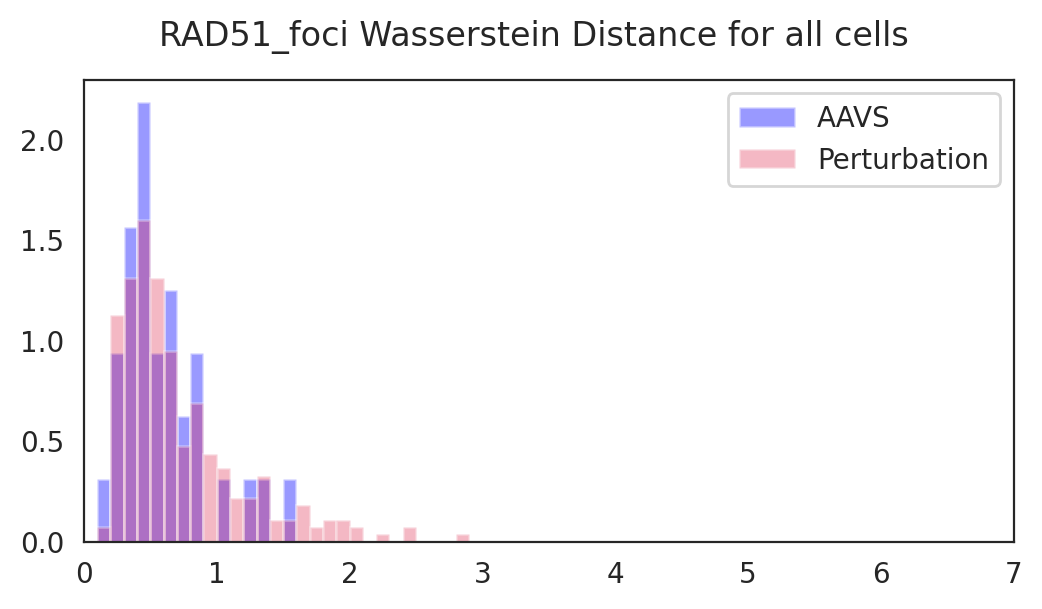

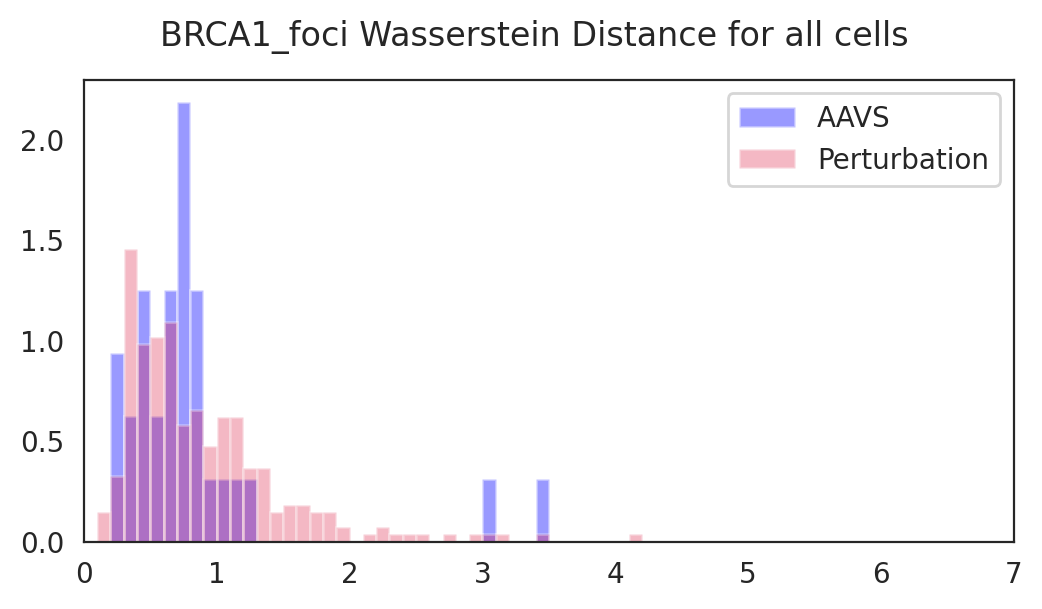

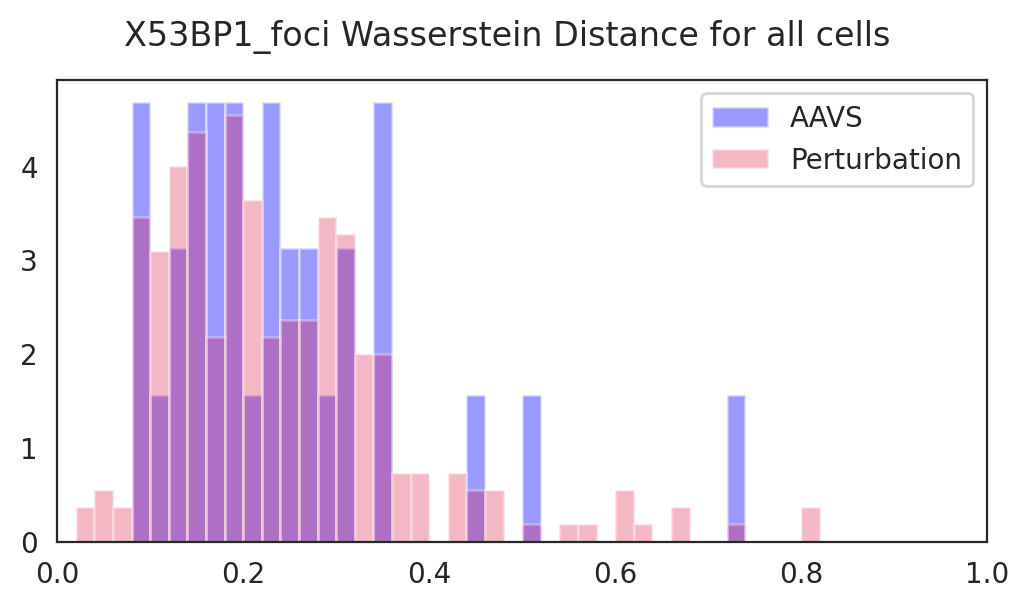

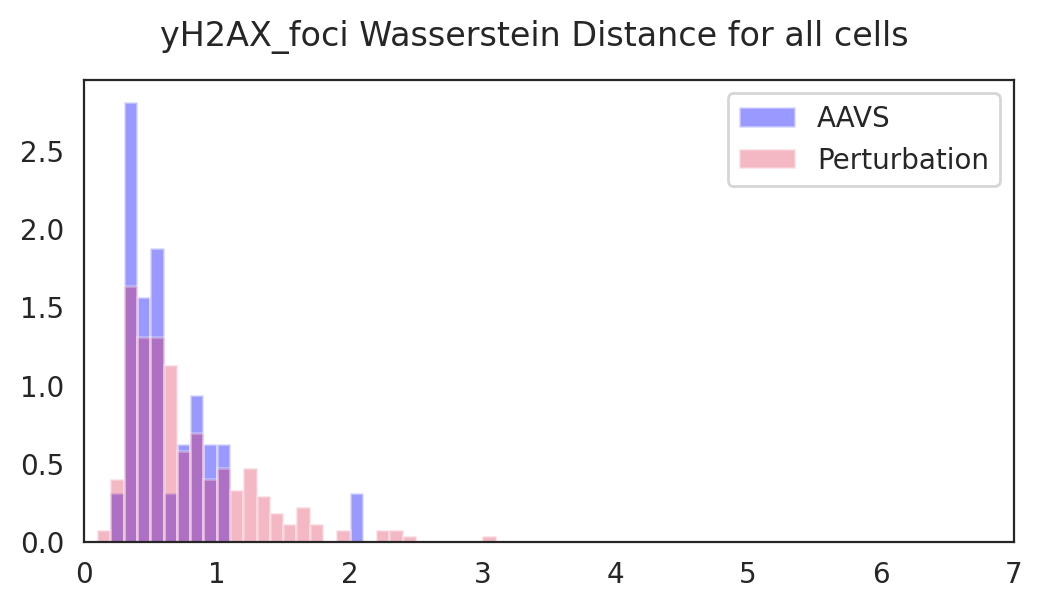

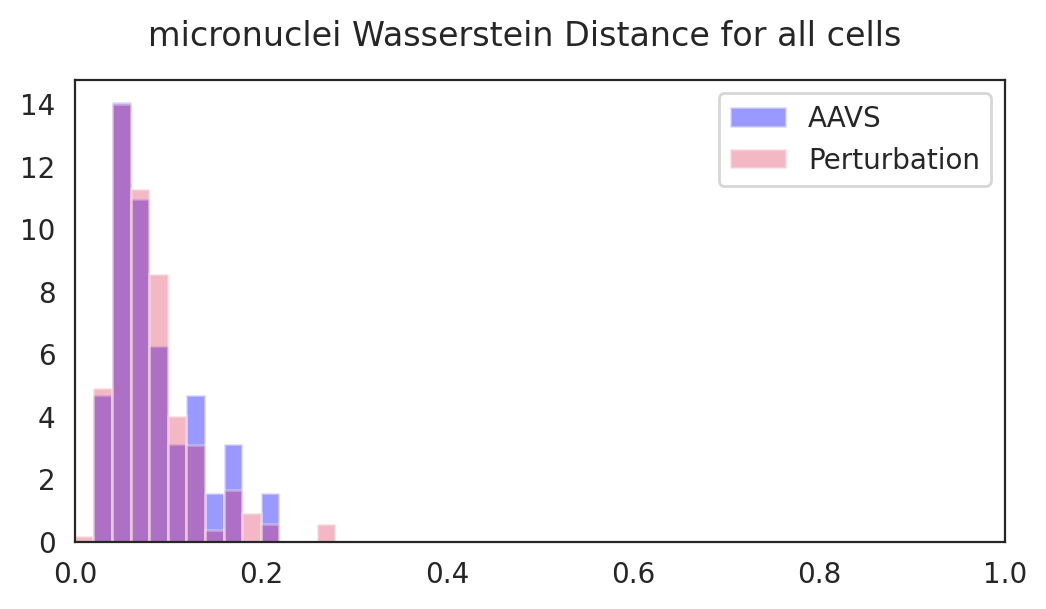

In [23]:
# Visualize Wasserstein distance distribution across different guide types for expression dataframe of interest

AAVS_guides = []
perturbs_guides = []
robust_guides = ["ATR.472", "ATR.151", "ATM.518", "ATM.251", "RAD51D.62", "RAD51D.1", "BRCA1.416", "BRCA2.207", "XRCC3.198", "BARD1.222"]

for column in foci_by_gene_dist.columns:
    if 'AAVS1' in column:
        AAVS_guides.append(column)
    else:
        perturbs_guides.append(column)

# robust_arr = []
AAVS_arr = []
perturbs_arr = []

# Loop through the five foci
for foc in foci:
    AAVS_arr = foci_by_gene_dist.loc[foc, AAVS_guides].values
    perturbs_arr = foci_by_gene_dist.loc[foc, perturbs_guides].values
    # robust_arr = foci_by_gene_dist.loc[foc, robust_guides].values

    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

    if foc == "X53BP1_foci" or foc == "micronuclei":
        bw = 0.02
        xlim_max = 1
    else:
        bw = 0.1
        xlim_max = 7

    if len(AAVS_arr) > 0:
        ax.hist(AAVS_arr, color="blue", density = True,bins=np.arange(int(AAVS_arr.min()), int(AAVS_arr.max())+1+bw, bw), alpha=0.4, label='AAVS') #density = True,

    if len(perturbs_arr) > 0:
        ax.hist(perturbs_arr, color='crimson', density = True,bins=np.arange(int(perturbs_arr.min()), int(perturbs_arr.max())+1+bw, bw),alpha=0.3, label='Perturbation')

    #if len(robust_arr) > 0:
         #ax.hist(robust_arr, color='yellow', density = True, bins=np.arange(int(robust_arr.min()), int(robust_arr.max())+1+bw, bw), alpha=0.3, label='Robust')

    plt.xlim(0, xlim_max)
    ax.legend()
    plt.suptitle(f'{foc} Wasserstein Distance for all cells')
    plt.show()

del robust_arr, AAVS_arr, perturbs_arr, perturbs_guides, AAVS_guides

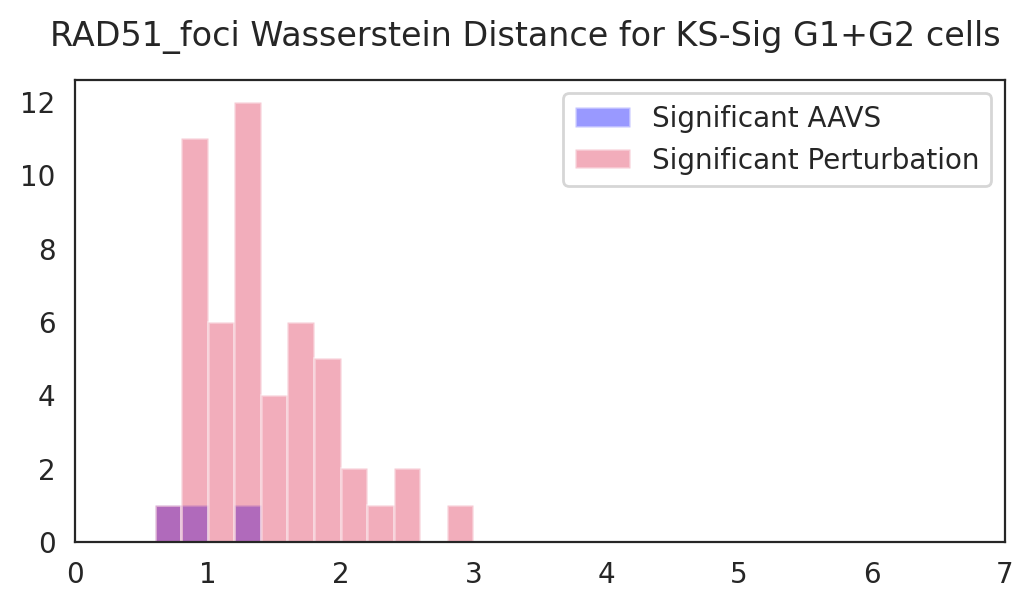

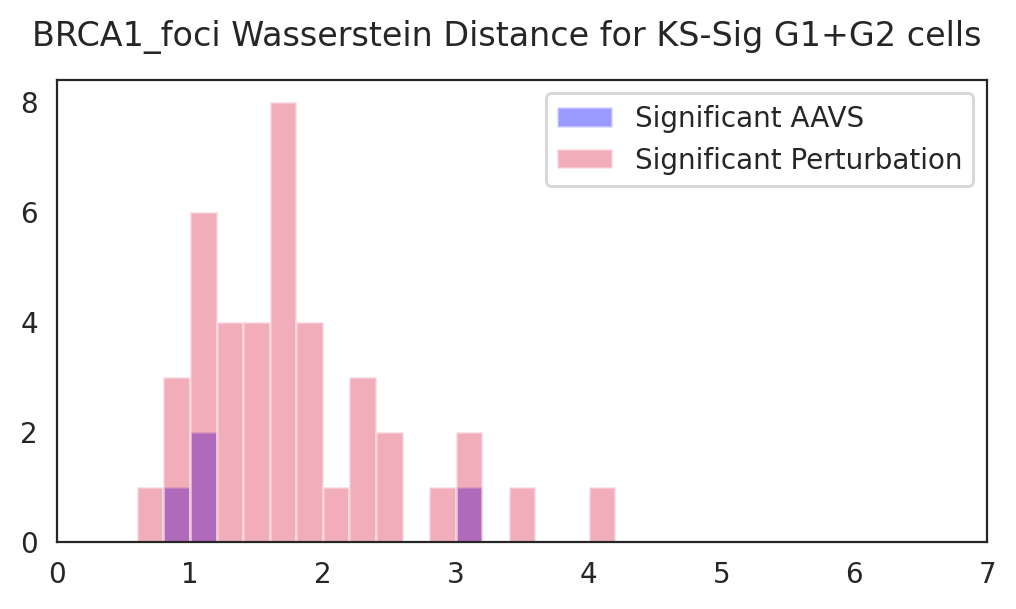

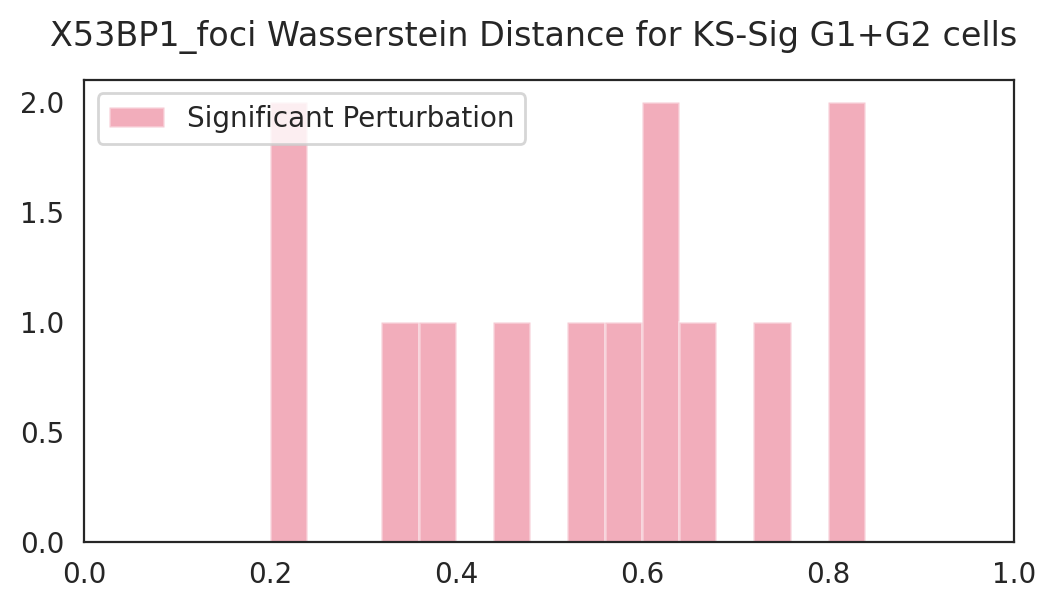

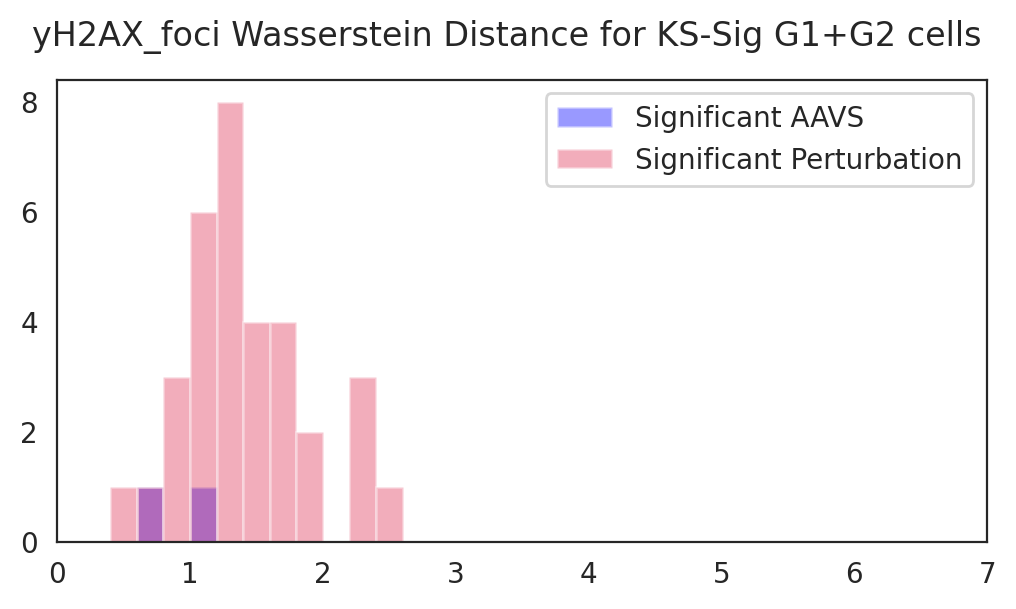

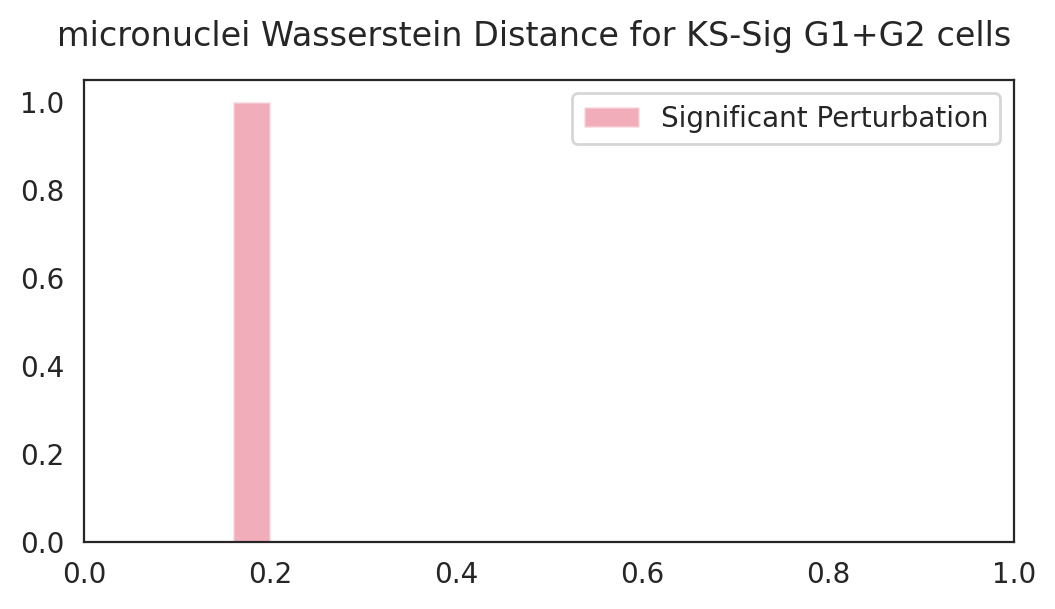

In [24]:
# Visualize KS-significant Wasserstein distance distribution across different guide types for expression dataframe of interest
for foc in foci:
    foci_sig_per = find_keys_with_foci(foc, gene_foci_dict)

    AAVS_guides = []
    perturbs_guides = []
    # Robust_guides = []

    # Loop through each element in foci_sig_per
    for guide in foci_sig_per:
        if "AAVS1" in guide:
            AAVS_guides.append(guide)
        # elif guide in robust_guides:
            # Robust_guides.append(guide)
            # perturbs_guides.append(guide)  # Add the guide to perturbs_guides as well
        else:
            perturbs_guides.append(guide)

    AAVS_arr = foci_by_gene_dist.loc[foc, AAVS_guides].values
    perturbs_arr = foci_by_gene_dist.loc[foc, perturbs_guides].values
    # robust_arr = foci_by_gene_dist.loc[foc, Robust_guides].values

    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

    if foc == "X53BP1_foci" or foc == "micronuclei":
        bw = 0.04
        xlim_max = 1
    else:
        bw = 0.2
        xlim_max = 7

    if len(AAVS_arr) > 0:
        ax.hist(AAVS_arr, color="blue", bins=np.arange(int(AAVS_arr.min()), int(AAVS_arr.max())+1+bw, bw), alpha=0.4, label='Significant AAVS') #density = True,

    if len(perturbs_arr) > 0:
        ax.hist(perturbs_arr, color='crimson', bins=np.arange(int(perturbs_arr.min()), int(perturbs_arr.max())+1+bw, bw),alpha=0.35, label='Significant Perturbation')

    #if len(robust_arr) > 0:
         #ax.hist(robust_arr, color='yellow', bins=np.arange(int(robust_arr.min()), int(robust_arr.max())+1+bw, bw), alpha=0.35, label='Significant Robust')

    plt.xlim(0, xlim_max)
    ax.legend()
    plt.suptitle(f'{foc} Wasserstein Distance for KS-Sig G1+G2 cells')
    plt.show()

We can observe a right shift of Wasserstein distance for KS-significant guides.